# Data Preparation
- This notebook is used to visualize and prepare power trace data for our transformer model.

In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

## Find and load the data

In [26]:
def discover_experiment_pairs(data_root_dir: str) -> List[Tuple[str, str]]:
    """
    Finds matching pairs of power CSVs and results CSVs based on
    {MODEL_NAME}_tp{TP}_p{RATE}_d{DATE}.csv and
    results_{MODEL_NAME}_{RATE}_{TP}_d{DATE}_final.csv.

    Returns:
        A list of (power_csv_path, results_csv_path).
    """
    all_csvs = glob.glob(
        os.path.join(data_root_dir, "**", "*.csv"), recursive=True
    )
    print(f"Found {len(all_csvs)} CSV files in {data_root_dir}")

    # Separate into "power" files vs "results" files
    power_files = []
    results_files = []

    for csv_path in all_csvs:
        base = os.path.basename(csv_path)
        if base.startswith("results_"):
            results_files.append(csv_path)
        else:
            # Likely a power file if it has _tp and _p in the name
            if "_tp" in base and "_p" in base:
                power_files.append(csv_path)

    print(f"Found {len(power_files)} power files and {len(results_files)} results files")
    
    # Attempt to match them by extracting model_name, tp, rate, and date
    def extract_power_info(filename: str):
        # Example: llama-3-8b_tp2_p1.0_d2025-04-07-20-19-17.csv
        base = os.path.basename(filename)
        model_match = re.match(r"(.*)_tp(\d+)_p([\d\.]+)_d(.*).csv", base)
        if not model_match:
            return None
        model_name = model_match.group(1)
        tp = model_match.group(2)
        rate = model_match.group(3)
        date = model_match.group(4)
        return model_name, tp, rate, date

    def extract_results_info(filename: str):
        # Example: results_llama-3-8b_1.0_2_d2025-04-07-20-19-17_final.csv
        base = os.path.basename(filename)
        # Try pattern with date
        result_match = re.match(r"results_(.*)_([\d\.]+)_(\d+)_d(.*)_final.csv", base)
        if not result_match:
            # Try the old pattern without date
            result_match = re.match(r"results_(.*)_([\d\.]+)_(\d+)_final.csv", base)
            if not result_match:
                return None
            model_name = result_match.group(1)
            rate = result_match.group(2)
            tp = result_match.group(3)
            date = None
        else:
            model_name = result_match.group(1)
            rate = result_match.group(2)
            tp = result_match.group(3)
            date = result_match.group(4)
        return model_name, tp, rate, date

    matched_pairs = []
    for pfile in power_files:
        pinfo = extract_power_info(pfile)
        if not pinfo:
            continue
        p_model, p_tp, p_rate, p_date = pinfo

        # Look for a results file that matches
        for rfile in results_files:
            rinfo = extract_results_info(rfile)
            if not rinfo:
                continue
            r_model, r_tp, r_rate, r_date = rinfo

            # Check if they match on model, tp, and rate
            if p_model == r_model and p_tp == r_tp and p_rate == r_rate:
                # If date is available in both, check if it matches
                if p_date and r_date:
                    if p_date == r_date:
                        matched_pairs.append((pfile, rfile))
                        break  # Found our match with date
                else:
                    # No date information, match by other criteria
                    matched_pairs.append((pfile, rfile))
                    break  # Found our match without date

    print(
        f"Found {len(power_files)} power files, {len(results_files)} results files, "
        f"matched {len(matched_pairs)} pairs."
    )
    return matched_pairs


def parse_results_csv(csv_path: str) -> pd.DataFrame:
    """
    Parse the results CSV.
    
    Expects columns:
    [Request Time, Model, Data Source, Poisson Arrival Rate, Tensor Parallel Size,
     Input Tokens, Output Tokens, E2E Latency]

    Returns:
        Pandas DataFrame with a 'Completion Time' column.
    """
    try:
        df = pd.read_csv(csv_path)
        df.sort_values("Request Time", inplace=True)
        
        # Handle both timestamp formats (ISO and Unix)
        if df["Request Time"].dtype == object:
            try:
                # Try parsing as ISO format first
                df["Request Time"] = pd.to_datetime(df["Request Time"])
                df["Request Time"] = df["Request Time"].astype(np.int64) // 10**9  # Convert to Unix timestamp
            except:
                # If that fails, assume it's already a Unix timestamp
                df["Request Time"] = pd.to_numeric(df["Request Time"])
        
        df["Completion Time"] = df["Request Time"] + df["E2E Latency"]
        
        # Extract model size based on model name pattern
        if "deepseek" in csv_path:
            df["Model Size"] = df["Model"].apply(lambda x: int(x.split("-")[-1].replace("B", "")))
        elif "llama-3" in csv_path:
            df["Model Size"] = df["Model"].apply(lambda x: int(x.split("-")[-2].replace("B", "")))
        else:
            print(f"Unknown model size format in {csv_path}, skipping model size.")
            
        return df
    except Exception as e:
        print(f"Error reading results file {csv_path}: {e}")
        return pd.DataFrame()


def parse_power_csv(csv_path: str) -> pd.DataFrame:
    """
    Parse the GPU power trace CSV and sum up the first X power values of each group of 8 rows,
    where X is the tensor parallelism extracted from the filename (_tpX).
    The timestamp for each sample is taken as the minimum timestamp within the group.
    
    Expects columns (for each GPU row):
        timestamp, power.draw [W], utilization.gpu [%], memory.used [MiB]
    """
    try:
        # Read CSV and clean up column names
        df = pd.read_csv(csv_path, skipinitialspace=True)
        df.columns = [col.strip().lower() for col in df.columns]

        # Rename power and memory columns if needed
        if "power.draw [w]" in df.columns:
            df.rename(columns={"power.draw [w]": "power"}, inplace=True)
            df.rename(columns={"memory.used [mib]": "memory"}, inplace=True)

        # Clean up the power column (remove non-numeric characters and convert to numeric)
        if df["power"].dtype == object:
            df["power"] = df["power"].replace(r"[^\d.]", "", regex=True)
            df["power"] = pd.to_numeric(df["power"])

        # Clean up the memory column if present
        if "memory" in df.columns and df["memory"].dtype == object:
            df["memory"] = df["memory"].replace(r"[^\d.]", "", regex=True)
            df["memory"] = pd.to_numeric(df["memory"])

        # Identify the timestamp column (any column containing "time")
        time_col = None
        for c in df.columns:
            if "time" in c:
                time_col = c
                break
        if not time_col:
            raise ValueError("No timestamp column found in power CSV")

        # Convert timestamps to datetime and rename column to "timestamp"
        df[time_col] = pd.to_datetime(df[time_col])
        df.rename(columns={time_col: "timestamp"}, inplace=True)

        # Extract tensor parallelism from the filename (_tpX -> X)
        tp_match = re.search(r'_tp(\d+)', csv_path)
        tensor_parallelism = int(tp_match.group(1)) if tp_match else 1
        print(f"Extracted tensor parallelism {tensor_parallelism} from {csv_path}")
        
        # Group by 8 rows (8 GPUs per node)
        num_rows = len(df)
        num_complete_groups = num_rows // 8
        df = df.iloc[:num_complete_groups * 8]
        groups = df.groupby(np.arange(len(df)) // 8)

        result = groups.apply(lambda x: pd.Series({
            "timestamp": x["timestamp"].min(),
            "power": x.iloc[:tensor_parallelism]["power"].sum()
        })).reset_index(drop=True)

        result["timestamp"] = pd.to_datetime(result['timestamp']).astype(np.int64) / 10**9

        return result

    except Exception as e:
        print(f"Error reading power file {csv_path}: {e}")
        return pd.DataFrame()


def extract_experiment_info(power_csv_path: str):
    """
    Extract experiment information from the power CSV filename.
    
    Args:
        power_csv_path: Path to the power CSV file
        
    Returns:
        Dict with model_name, tp, rate, and date
    """
    base = os.path.basename(power_csv_path)
    model_match = re.match(r"(.*)_tp(\d+)_p([\d\.]+)_d(.*).csv", base)
    if not model_match:
        return None
    
    return {
        "model_name": model_match.group(1),
        "tp": int(model_match.group(2)),
        "rate": float(model_match.group(3)),
        "date": model_match.group(4)
    }


def load_and_process_experiments(data_root_dir: str, exclude_patterns=None):
    """
    Load and process all experiment pairs, organizing them into coordinated lists.
    
    Args:
        data_root_dir: Root directory to search for CSV files
        exclude_patterns: List of patterns to exclude (e.g., ['deepseek'])
        
    Returns:
        power_dfs: List of power dataframes
        results_dfs: List of results dataframes
        experiment_info: List of dictionaries with experiment metadata
    """
    # Find matching experiment pairs
    matched_pairs = discover_experiment_pairs(data_root_dir)
    
    # Filter out excluded patterns
    if exclude_patterns:
        filtered_pairs = []
        for pair in matched_pairs:
            should_include = True
            for pattern in exclude_patterns:
                if (pattern.lower() in pair[0].lower() or 
                    pattern.lower() in pair[1].lower()):
                    should_include = False
                    break
            if should_include:
                filtered_pairs.append(pair)
        
        print(f"Filtered out {len(matched_pairs) - len(filtered_pairs)} pairs. Remaining pairs: {len(filtered_pairs)}")
        matched_pairs = filtered_pairs
    
    # Process each pair
    power_dfs = []
    results_dfs = []
    experiment_info = []
    
    for power_csv, results_csv in matched_pairs:
        print(f"Processing {power_csv} and {results_csv}")
        
        # Extract experiment information
        info = extract_experiment_info(power_csv)
        if not info:
            print(f"Could not extract experiment info from {power_csv}")
            continue
        
        # Parse CSV files
        power_df = parse_power_csv(power_csv)
        results_df = parse_results_csv(results_csv)
        
        # Skip if parsing failed
        if power_df.empty or results_df.empty:
            print(f"Skipping empty dataframes for {power_csv} and {results_csv}")
            continue
        
        # Add to our lists
        power_dfs.append(power_df)
        results_dfs.append(results_df)
        experiment_info.append(info)
    
    print(f"Successfully processed {len(power_dfs)} experiment pairs")
    return power_dfs, results_dfs, experiment_info

def plot_power_val(df: pd.DataFrame, title: str, ylabel: str, xlabel: str, save_path: Optional[str] = None):
    plt.figure(figsize=(12, 6))
    plt.plot(df["timestamp"], df["power"], label="Power")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()  # Fixed from plt.legCompletion()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [27]:
power_dfs, results_dfs, experiment_info = load_and_process_experiments(
        "../client", 
        exclude_patterns=["deepseek", "old-but-good"]
    )


Found 853 CSV files in ../client
Found 287 power files and 566 results files
Found 287 power files, 566 results files, matched 275 pairs.
Filtered out 73 pairs. Remaining pairs: 202
Processing ../client/llama-3-8b/llama-3-8b_tp2_p0.5_d2025-04-27-01-09-03.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_2_d2025-04-27-01-09-03_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p0.5_d2025-04-27-01-09-03.csv
Processing ../client/llama-3-8b/llama-3-8b_tp4_p1.0_d2025-04-27-07-25-12.csv and ../client/llama-3-8b/results_llama-3-8b_1.0_4_d2025-04-27-07-25-12_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p1.0_d2025-04-27-07-25-12.csv
Processing ../client/llama-3-8b/llama-3-8b_tp4_p0.25_d2025-04-27-06-04-31.csv and ../client/llama-3-8b/results_llama-3-8b_0.25_4_d2025-04-27-06-04-31_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p0.25_d2025-04-27-06-04-31.csv
Processing ../client/llama-3-8b/lla

0      70
1      70
2      70
3      70
4      70
       ..
585    70
586    70
587    70
588    70
589    70
Name: Model Size, Length: 590, dtype: int64


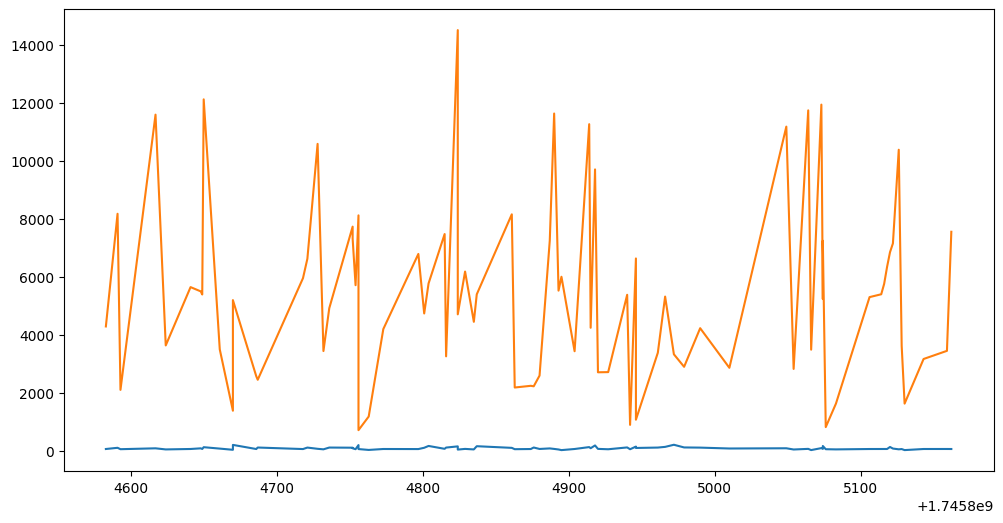

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(results_dfs[-9]["Request Time"], results_dfs[-9]["Decode Throughput"])
plt.plot(results_dfs[-9]["Request Time"], results_dfs[-9]["Prefill Throughput"])
# plt.plot(results_dfs[-10]["Request Time"], results_dfs[-10]["Decode Tokens"])
plt.show()

In [29]:
# check that power and results dataframes have same date for their timestamps
sort_power_dfs = power_dfs.copy()
sort_results_dfs = results_dfs.copy()
for i in range(len(sort_power_dfs)):
    print(sort_results_dfs[i]["Request Time"].min())
    sort_power_dfs[i]["timestamp"] -= sort_power_dfs[i]["timestamp"].min() 
    sort_results_dfs[i]["Completion Time"] -= sort_results_dfs[i]["Request Time"].min()
    sort_results_dfs[i]["Request Time"] -= sort_results_dfs[i]["Request Time"].min()
    poisson_arrival_rate = results_dfs[i]["Poisson Arrival Rate"].iloc[0]
    # simulated_arrival_time = np.random.exponential(1.0 / poisson_arrival_rate)
    # sort_results_dfs[i]["Request Time"] += simulated_arrival_time
    # sort_results_dfs[i]["Completion Time"] += simulated_arrival_time


print("Power DataFrames:")
# for power_df in sort_power_dfs:
#     print(power_df.head())
print("Results DataFrames:")
for results_df in sort_results_dfs:
    print(results_df[["Request Time", "Completion Time"]].max())



1745716148
1745738717
1745733883
1745639479.545437
1745727218
1745731456
1745753982
1745711326
1745718582
1745725427
1745742506
1745622342.520371
1745609697.548386
1745737510
1745722410
1745720367
1745580611.4106965
1745713122
1745598626.1299193
1745566167.4907374
1745723008
1745730246
1745735694
1745746136
1745586251.3945403
1745714334
1745615881.201382
1745710720
1745712518
1745736299
1745726617
1745744338
1745572422.0918958
1745592728.306078
1745747347
1745752168
1745757618
1745730856
1745588334.3266678
1745574738.132905
1745753375
1745607363.87567
1745738112
1745628354.9813557
1745723610
1745711919
1745751578
1745603125.160427
1745749159
1745756405
1745570048.9535372
1745745532
1745703392.3104737
1745743718
1745733281
1745611262.7591047
1745617894.9773002
1745605297.2767093
1745747961
1745757012
1745734482
1745630716.4682622
1745717966
1745735089
1745724822
1745713728
1745596376.5317588
1745754588
1745741901
1745707893.883988
1745746744
1745750361
1745578610.7061636
1745727823
1745

In [32]:
import datetime
def add_token_columns_to_power_df(power_df: pd.DataFrame, results_df: pd.DataFrame) -> pd.DataFrame:
    """
    For each time window in power_df, compute the tokens that are being processed by 
    tracking prefill and decode tokens across the processing duration.
    
    Args:
        power_df: DataFrame with a 'timestamp' column (in seconds relative to experiment start).
        results_df: DataFrame from the results CSV. Expects columns:
            - "Request Time" (datetime64)
            - "Completion Time" (datetime64)
            - "Prefill Tokens"
            - "Decode Tokens"
    
    Returns:
        The original power_df with added columns:
            - "prefill_tokens": the prefill tokens being processed in that window
            - "decode_tokens": the decode tokens being processed in that window
            - "batch_size": the batch size being processed in that window
            - "effective_batch_size": the effective batch size in that window
    """
    # Use the earliest request time as the reference
    start_time = results_df["Request Time"].min()
    
    # Create new columns with times in seconds relative to start_time
    results_df = results_df.copy()
    results_df["req_sec"] = (results_df["Request Time"] - start_time)
    results_df["comp_sec"] = (results_df["Completion Time"] - start_time)
    
    window_duration = 0.25  # 250ms window
    prefill_tokens_list = []
    decode_tokens_list = []
    batch_size_list = []
    effective_batch_list = []
    prefill_throughput_list = []
    decode_throughput_list = []

    for t in power_df["timestamp"]:
        window_start = t
        window_end = t + window_duration
        
        # Find all requests that overlap with this time window
        overlapping = results_df[(results_df["comp_sec"] > window_start) & (results_df["req_sec"] < window_end)]
        
        total_prefill = 0.0
        total_decode = 0.0
        total_batch = 0.0
        total_effective_batch = 0.0
        total_prefill_throughput = 0.0
        total_decode_throughput = 0.0
        
        # For each overlapping query, compute the tokens being processed in this window
        for _, row in overlapping.iterrows():
            q_start = row["req_sec"]
            q_end = row["comp_sec"]
            
            # Compute the overlap (in seconds) between the query interval and the window
            overlap = max(0.0, min(window_end, q_end) - max(window_start, q_start))
            query_duration = q_end - q_start
            
            if query_duration > 0:
                fraction = overlap / query_duration
                # Use prefill and decode columns instead of input/output tokens
                total_prefill += row["Prefill Tokens"] * fraction
                total_decode += row["Decode Tokens"] * fraction
                total_batch += row["Batch Size"] * fraction
                total_effective_batch += row["Effective Batch Size"] * fraction
                total_prefill_throughput += row["Prefill Throughput"] * fraction
                total_decode_throughput += row["Decode Throughput"] * fraction
        
        prefill_tokens_list.append(total_prefill)
        decode_tokens_list.append(total_decode)
        batch_size_list.append(total_batch)
        effective_batch_list.append(total_effective_batch)
        prefill_throughput_list.append(total_prefill_throughput)
        decode_throughput_list.append(total_decode_throughput)
    
    # Add the new columns to the power_df
    power_df["prefill_tokens"] = prefill_tokens_list
    power_df["decode_tokens"] = decode_tokens_list
    power_df["batch_size"] = batch_size_list
    power_df["effective_batch_size"] = effective_batch_list
    power_df["prefill_throughput"] = prefill_throughput_list
    power_df["decode_throughput"] = decode_throughput_list
    
    return power_df

truncated_power_dfs = []
for i in range(len(sort_power_dfs)):
    date = sort_power_dfs[i]['timestamp'].min()
    print("Power date: ", datetime.datetime.fromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S'))
    startup_cutoff = sort_results_dfs[i]["Request Time"].min()
    shutdown_cutoff = sort_results_dfs[i]["Completion Time"].max()
    print("Startup time: ", startup_cutoff - date)
    print("Shutdown time: ", shutdown_cutoff - date)
    truncated_power_dfs.append(sort_power_dfs[i][(sort_power_dfs[i]['timestamp'] > startup_cutoff) & (sort_power_dfs[i]['timestamp'] < shutdown_cutoff)])
    truncated_power_dfs[i].reset_index(drop=True, inplace=True)
    truncated_power_dfs[i]['timestamp'] -= truncated_power_dfs[i]['timestamp'].min()


# Add token columns to power dataframes
for i in range(len(truncated_power_dfs)):
    truncated_power_dfs[i] = add_token_columns_to_power_df(truncated_power_dfs[i], sort_results_dfs[i])
    print(truncated_power_dfs[i].head())

output_path = "processed_data/power_trace_data.npz"
prefill_tokens = []
decode_tokens = []
batch_sizes = []
effective_batch_sizes = []
prefill_throughputs = []
decode_throughputs = []
tensor_parallelism = []
poisson_rate = []
model_sizes = [] 
power_traces = []
hardware = []

# First pass to get max length
max_len = max([len(df) for df in truncated_power_dfs])

for i in range(len(truncated_power_dfs)):
    print(len(truncated_power_dfs[i]), len(sort_results_dfs[i]))
    tensor_parallelism.append(sort_results_dfs[i]["Tensor Parallel Size"].iloc[0])
    poisson_rate.append(sort_results_dfs[i]["Poisson Arrival Rate"].iloc[0])
    model_size = sort_results_dfs[i]["Model"].iloc[0].split("-")[-2].replace("B", "")
    model_sizes.append(int(model_size))
    
    # Pad power traces and token arrays to max length
    power_trace = truncated_power_dfs[i]["power"].values
    prefill_token = truncated_power_dfs[i]["prefill_tokens"].values
    decode_token = truncated_power_dfs[i]["decode_tokens"].values
    batch_size = truncated_power_dfs[i]["batch_size"].values
    effective_batch_size = truncated_power_dfs[i]["effective_batch_size"].values
    prefill_throughput = truncated_power_dfs[i]["prefill_throughput"].values
    decode_throughput = truncated_power_dfs[i]["decode_throughput"].values

    # Pad with zeros to maintain homogeneity
    power_trace = np.pad(power_trace, (0, max_len - len(power_trace)), 'edge')
    prefill_token = np.pad(prefill_token, (0, max_len - len(prefill_token)), 'edge')
    decode_token = np.pad(decode_token, (0, max_len - len(decode_token)), 'edge')
    batch_size = np.pad(batch_size, (0, max_len - len(batch_size)), 'edge')
    effective_batch_size = np.pad(effective_batch_size, (0, max_len - len(effective_batch_size)), 'edge')
    prefill_throughput = np.pad(prefill_throughput, (0, max_len - len(prefill_throughput)), 'edge')
    decode_throughput = np.pad(decode_throughput, (0, max_len - len(decode_throughput)), 'edge')

    power_traces.append(power_trace)
    prefill_tokens.append(prefill_token)
    decode_tokens.append(decode_token)
    batch_sizes.append(batch_size)
    effective_batch_sizes.append(effective_batch_size)
    prefill_throughputs.append(prefill_throughput)
    decode_throughputs.append(decode_throughput)
    hardware.append("A100")


# Convert to numpy arrays
power_traces = np.array(power_traces)
tensor_parallelism = np.array(tensor_parallelism)
poisson_rate = np.array(poisson_rate)
model_sizes = np.array(model_sizes)
prefill_tokens = np.array(prefill_tokens)
decode_tokens = np.array(decode_tokens)
hardware = np.array(hardware)

np.savez(output_path, 
        power_traces=power_traces, 
        tensor_parallelism=tensor_parallelism, 
        poisson_rate=poisson_rate, 
        model_size=model_sizes, 
        prefill_tokens=prefill_tokens,
        decode_tokens=decode_tokens,
        batch_sizes=batch_sizes,
        effective_batch_sizes=effective_batch_sizes,    
        prefill_throughputs=prefill_throughputs,
        decode_throughputs=decode_throughputs,
        hardware=hardware
        )


Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  599.2283079624176
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  599.3434982299805
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  589.7768580913544
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  584.748693227768
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.2888209819794
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.9996309280396
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.8820555210114
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  576.2187781333923
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  565.0302412509918
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  599.2151725292206
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shutdown time:  598.7710337638855
Power date:  1969-12-31 16:00:00
Startup time:  0.0
Shu

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_power_dfs[i]['timestamp'] -= truncated_power_dfs[i]['timestamp'].min()
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is tryin

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  168.67      138.673282     232.394236    0.897896   
1      0.250  168.33      138.673282     232.394236    0.897896   
2      0.501  168.00      138.673282     232.394236    0.897896   
3      0.751  168.00      128.794149     226.421366    0.842008   
4      1.001  149.73       65.736406     250.828903    0.544461   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.042537         5916.592682          97.079950  
1              2.042537         5916.592682          97.079950  
2              2.042537         5916.592682          97.079950  
3              1.890126         5390.787292          90.357327  
4              1.163541         1981.667805          58.761140  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  333.41       93.262725      84.433118    0.551850   
1      0.250  332.59       93.262725      84.433118    0.551850   
2      0.501  331.84       93.262725      84.433118    0.551850   
3      0.751  332.12       57.996545      52.699554    0.343650   
4      1.002  331.92       39.439141      84.160309    0.352135   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.366891        11055.993843          96.581732  
1              1.366891        11055.993843          96.581732  
2              1.366891        11055.993843          96.581732  
3              0.850153         6865.291628          60.045486  
4              0.611878         2172.499237          37.086536  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  329.45       18.130046      39.886102         0.0   
1      0.250  329.17       18.130046      39.886102         0.0   
2      0.501  328.56       18.130046      39.886102         0.0   
3      0.751  328.56       18.130046      39.886102         0.0   
4      1.002  314.13       17.334768      38.136490         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.293011         1963.742262          33.126764  
1              0.293011         1963.742262          33.126764  
2              0.293011         1963.742262          33.126764  
3              0.293011         1963.742262          33.126764  
4              0.280158         1877.602308          31.673652  
   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  176.69       27.490939      29.910142         0.0   
1      0.251  176.41       27.490939      29.910142         0.0   
2     

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  327.53      189.889569     155.455945    0.595944   
1      0.251  327.52      189.889569     155.455945    0.595944   
2      0.501  327.20      189.889569     155.455945    0.595944   
3      0.752  287.11      190.217033     156.535629    0.597871   
4      1.002  270.49      184.878353     241.671323    0.703691   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.989098        11284.845242          90.607429  
1              1.989098        11284.845242          90.607429  
2              1.989098        11284.845242          90.607429  
3              1.995726        11309.600427          91.255788  
4              2.218339        12460.296762         151.161902  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  333.14       24.043283      51.258944    0.166967   
1      0.251  332.78       24.043283      51.258944    0.166967   
2      0.501  332.54       24.043283      51.258944    0.166967   
3      0.752  331.92       24.388047      51.875626    0.168079   
4      1.002  317.16       67.136703     128.340562    0.305978   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.328831         2972.799898          35.052804  
1              0.328831         2972.799898          35.052804  
2              0.328831         2972.799898          35.052804  
3              0.330628         2995.123469          35.175324  
4              0.553457         5763.115922          50.367051  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  661.61       38.165064      41.390281    0.000000   
1      0.251  660.35       38.165064      41.390281    0.000000   
2      0.501  659.77       38.165064      41.390281    0.000000   
3      0.752  659.42       28.513115      31.445104    0.003529   
4      1.002  631.31      164.197571     243.374103    0.441095   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.516593         3133.147261          46.594540  
1              0.516593         3133.147261          46.594540  
2              0.516593         3133.147261          46.594540  
3              0.372804         2261.697131          33.342074  
4              0.579761         3595.603365          16.884675  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  170.76       30.294265      65.796713    0.086803   
1      0.250  170.76       30.294265      65.796713    0.086803   
2      0.501  170.21       30.294265      65.796713    0.086803   
3      0.751  170.21       30.423312      66.360347    0.088034   
4      1.001  169.69       62.550615     206.681872    0.394565   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.297495         1414.776809          14.749415  
1              0.297495         1414.776809          14.749415  
2              0.297495         1414.776809          14.749415  
3              0.299901         1424.015978          14.960986  
4              0.898843         3724.185973          67.633439  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  170.21       12.211873      64.353022    0.025336   
1      0.250  169.89       12.211873      64.353022    0.025336   
2      0.501  169.89       12.211873      64.353022    0.025336   
3      0.751  169.27       12.211873      64.353022    0.025336   
4      1.002  139.88       12.211873      64.353022    0.025336   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.070243          351.242387           4.883329  
1              0.070243          351.242387           4.883329  
2              0.070243          351.242387           4.883329  
3              0.070243          351.242387           4.883329  
4              0.070243          351.242387           4.883329  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  334.59      414.309868     403.342571    1.540222   
1      0.251  334.26      414.309868     403.342571    1.540222   
2      0.501  333.74      314.953255     366.776382    1.170867   
3      0.752  333.68      204.897051     330.062118    0.768917   
4      1.002  317.83      546.721584     925.819845    2.930124   

   effective_batch_size  prefill_throughput  decode_throughput  
0              4.392162        29818.862689         182.545146  
1              4.392162        29818.862689         182.545146  
2              2.793070        18422.801953         121.214556  
3              1.003738         5575.903981          52.397120  
4              4.268594        17053.092352         153.993174  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  661.89       168.77303     160.612815    0.261289   
1      0.250  661.70       168.77303     160.612815    0.261289   
2      0.501  661.31       168.77303     160.612815    0.261289   
3      0.751  649.61       168.77303     160.612815    0.261289   
4      1.002  567.57       168.77303     160.612815    0.261289   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.696737         6309.893641          43.558087  
1              0.696737         6309.893641          43.558087  
2              0.696737         6309.893641          43.558087  
3              0.696737         6309.893641          43.558087  
4              0.696737         6309.893641          43.558087  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.75        9.737241      20.274803         0.0   
1      0.250  86.75        9.737241      20.274803         0.0   
2      0.500  86.48        9.737241      20.274803         0.0   
3      0.751  86.15        9.737241      20.274803         0.0   
4      1.001  86.15        9.737241      20.274803         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.980859          561.525998          11.129583  
1              0.980859          561.525998          11.129583  
2              0.980859          561.525998          11.129583  
3              0.980859          561.525998          11.129583  
4              0.980859          561.525998          11.129583  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.48       34.620491      60.718472    0.106089   
1      0.251  86.15       34.620491      60.718472    0.106089   
2      0.501  85.87       34.620491      60.718472    0.106089   
3      0.752  85.87       34.620491      60.718472    0.106089   
4      1.002  70.83       34.620491      60.718472    0.106089   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.193603          547.023489           6.319939  
1              0.193603          547.023489           6.319939  
2              0.193603          547.023489           6.319939  
3              0.193603          547.023489           6.319939  
4              0.193603          547.023489           6.319939  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  326.58       23.199012      39.557289         0.0   
1      0.250  326.31       23.199012      39.557289         0.0   
2      0.500  326.58       23.199012      39.557289         0.0   
3      0.751  326.40        8.310175      14.169914         0.0   
4      1.001  285.69        0.000000       0.000000         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.471852         3075.719185          49.381030  
1              0.471852         3075.719185          49.381030  
2              0.471852         3075.719185          49.381030  
3              0.169023         1101.760969          17.688901  
4              0.000000            0.000000           0.000000  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  285.31        4.465388      38.819391    0.021063   
1      0.250  283.49        4.465388      38.819391    0.021063   
2      0.501  283.09        4.465388      38.819391    0.021063   
3      0.751  283.16        4.465388      38.819391    0.021063   
4      1.002  282.83        4.465388      38.819391    0.021063   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.025492           59.460776           3.574462  
1              0.025492           59.460776           3.574462  
2              0.025492           59.460776           3.574462  
3              0.025492           59.460776           3.574462  
4              0.025492           59.460776           3.574462  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  168.94       90.761706      89.843431    0.701725   
1      0.250  168.00       71.484273      66.282125    0.433983   
2      0.500  168.00       45.122967      34.062751    0.067854   
3      0.751  140.20       45.122967      34.062751    0.067854   
4      1.001  138.66       45.122967      34.062751    0.067854   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.384738         6347.287490         163.101628  
1              1.453461         4255.332641          97.811110  
2              0.179968         1394.647794           8.528304  
3              0.179968         1394.647794           8.528304  
4              0.179968         1394.647794           8.528304  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  87.69       21.057098      39.654974    0.025617   
1      0.250  87.36       21.057098      39.654974    0.025617   
2      0.501  87.08       21.057098      39.654974    0.025617   
3      0.751  86.75       21.057098      39.654974    0.025617   
4      1.002  86.75       25.654448      52.058241    0.073506   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.171030          299.356551           2.292598  
1              0.171030          299.356551           2.292598  
2              0.171030          299.356551           2.292598  
3              0.171030          299.356551           2.292598  
4              0.490871          577.997991          10.062660  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  166.79       94.624633      97.257972    0.175556   
1      0.251  167.46       94.624633      97.257972    0.175556   
2      0.504  167.40       94.624633      97.257972    0.175556   
3      0.755  152.71       98.686438     104.437670    0.203785   
4      1.005  152.47      297.710208     456.234639    1.586973   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.411765         1618.252555          11.562268  
1              0.411765         1618.252555          11.562268  
2              0.411765         1618.252555          11.562268  
3              0.457667         1770.456239          14.562658  
4              2.706806         9228.262579         161.578317  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  87.36      143.931799     103.022417    0.762195   
1      0.251  87.08      175.577651     122.426884    0.976018   
2      0.501  87.08      222.282687     175.693784    1.362010   
3      0.752  87.08      241.755033     198.747371    1.512091   
4      1.002  70.83      315.104879     307.685177    1.793896   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.724802         3692.065849          39.819773  
1              2.149659         4889.627068          53.120415  
2              3.172248         5869.707122          71.879482  
3              3.555584         6240.965874          78.905810  
4              3.875570         6663.016628          84.600916  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  82.18       19.543995      14.742237         0.0   
1      0.251  82.18       19.543995      14.742237         0.0   
2      0.501  67.75       19.543995      14.742237         0.0   
3      0.752  67.75       19.543995      14.742237         0.0   
4      1.002  67.75       19.543995      14.742237         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.195921           625.75136           6.917708  
1              0.195921           625.75136           6.917708  
2              0.195921           625.75136           6.917708  
3              0.195921           625.75136           6.917708  
4              0.195921           625.75136           6.917708  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  328.88       42.731917      38.396795         0.0   
1      0.250  328.55       42.731917      38.396795         0.0   
2      0.501  328.13       42.731917      38.396795         0.0   
3      0.751  274.29       42.731917      38.396795         0.0   
4      1.002  271.32       35.730462      32.105633         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.436176         2879.112648          32.869218  
1              0.436176         2879.112648          32.869218  
2              0.436176         2879.112648          32.869218  
3              0.436176         2879.112648          32.869218  
4              0.364710         2407.381511          27.483728  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  328.57       28.754897      52.232678    0.035899   
1      0.251  327.48       28.754897      52.232678    0.035899   
2      0.501  327.81       28.754897      52.232678    0.035899   
3      0.752  315.61       28.754897      52.232678    0.035899   
4      1.002  272.16       28.754897      52.232678    0.035899   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.075407         2540.466443           7.547763  
1              0.075407         2540.466443           7.547763  
2              0.075407         2540.466443           7.547763  
3              0.075407         2540.466443           7.547763  
4              0.075407         2540.466443           7.547763  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  336.14      105.766239      96.098992    0.081926   
1      0.250  335.57      105.766239      96.098992    0.081926   
2      0.501  335.29      105.766239      96.098992    0.081926   
3      0.751  334.68      105.766239      96.098992    0.081926   
4      1.001  321.53      105.766239      96.098992    0.081926   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.448589         1623.556528          14.833461  
1              0.448589         1623.556528          14.833461  
2              0.448589         1623.556528          14.833461  
3              0.448589         1623.556528          14.833461  
4              0.448589         1623.556528          14.833461  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  660.97        23.76775      74.313139    0.069193   
1      0.250  659.46        23.76775      74.313139    0.069193   
2      0.501  659.50        23.76775      74.313139    0.069193   
3      0.751  658.86        23.76775      74.313139    0.069193   
4      1.001  604.71        23.76775      74.313139    0.069193   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.085585          856.640513           6.641701  
1              0.085585          856.640513           6.641701  
2              0.085585          856.640513           6.641701  
3              0.085585          856.640513           6.641701  
4              0.085585          856.640513           6.641701  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  88.02      246.546640     400.886975    0.410620   
1      0.252  87.69      537.913723     663.229362    2.442365   
2      0.503  87.36      660.429264     793.491172    3.252246   
3      0.753  87.36     1033.335309    1263.799232    5.386115   
4      1.004  71.44     1048.024646    1284.535952    5.455568   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.349327          528.122987           4.489819  
1              1.837774        10512.523559          90.451391  
2              2.334491        12631.458864         109.305693  
3              3.499401        16215.943214         142.486072  
4              3.537286        16305.455323         143.259509  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  170.76     1194.403862    1751.649865    4.047030   
1      0.251  170.76     1194.403862    1751.649865    4.047030   
2      0.501  170.48     1194.403862    1751.649865    4.047030   
3      0.752  169.89     1199.516640    1762.985397    4.118919   
4      1.002  157.29     1833.471175    3168.525201   13.032787   

   effective_batch_size  prefill_throughput  decode_throughput  
0              6.607431         8396.381220          83.749416  
1              6.607431         8396.381220          83.749416  
2              6.607431         8396.381220          83.749416  
3              6.711881         8568.872527          87.755519  
4             19.663012        29956.786970         584.488912  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.48     1377.153160     301.279141    3.537312   
1      0.251  86.15     1474.859459     348.583740    3.773436   
2      0.501  85.87     1651.611356     545.841092    4.145840   
3      0.751  85.54     1831.849605     649.927022    5.083781   
4      1.002  70.50     1457.575589    1057.850867    6.508244   

   effective_batch_size  prefill_throughput  decode_throughput  
0              3.907058         8501.140526         127.261894  
1              4.126755         9075.027683         136.001759  
2              4.317115         9297.361473         139.017267  
3              5.098508         9936.950738         157.023300  
4              5.919040         4851.393977         140.415565  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  134.62      156.937855     123.251024    0.935745   
1      0.250  134.29      156.937855     123.251024    0.935745   
2      0.500  134.42      156.937855     123.251024    0.935745   
3      0.751  134.29      164.711949     130.045951    0.974103   
4      1.001  134.62     2100.139023    1821.700987   10.523483   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.524224         1686.173697          47.444473  
1              2.524224         1686.173697          47.444473  
2              2.524224         1686.173697          47.444473  
3              2.630280         1778.020821          50.115997  
4             29.033894        24644.144976         715.214723  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  169.98       29.504886      41.040195         0.0   
1      0.250  169.60       29.504886      41.040195         0.0   
2      0.501  169.27       29.504886      41.040195         0.0   
3      0.751  168.94       29.504886      41.040195         0.0   
4      1.001  139.88       29.504886      41.040195         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.140528          743.330727           6.768645  
1              0.140528          743.330727           6.768645  
2              0.140528          743.330727           6.768645  
3              0.140528          743.330727           6.768645  
4              0.140528          743.330727           6.768645  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  338.89      417.074516     375.898805    1.875398   
1      0.250  336.47      417.074516     375.898805    1.875398   
2      0.501  335.90      417.074516     375.898805    1.875398   
3      0.751  335.29      419.669562     380.981831    1.888497   
4      1.002  330.99     1065.882883    1646.747348    5.150193   

   effective_batch_size  prefill_throughput  decode_throughput  
0              3.391937        28051.391327         182.961249  
1              3.391937        28051.391327         182.961249  
2              3.391937        28051.391327         182.961249  
3              3.409651        28089.213930         183.428935  
4              7.820765        37507.727464         299.891160  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  330.91       44.475815      47.055749         0.0   
1      0.250  330.33       44.475815      47.055749         0.0   
2      0.501  330.24       44.475815      47.055749         0.0   
3      0.751  315.63       44.475815      47.055749         0.0   
4      1.001  271.26       44.475815      47.055749         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.133428         1228.156266           8.584497  
1              0.133428         1228.156266           8.584497  
2              0.133428         1228.156266           8.584497  
3              0.133428         1228.156266           8.584497  
4              0.133428         1228.156266           8.584497  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  668.00          6.1779      41.160257         0.0   
1      0.250  666.47          6.1779      41.160257         0.0   
2      0.501  666.24          6.1779      41.160257         0.0   
3      0.751  664.98          6.1779      41.160257         0.0   
4      1.002  625.58          6.1779      41.160257         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.088815          718.888816          12.879859  
1              0.088815          718.888816          12.879859  
2              0.088815          718.888816          12.879859  
3              0.088815          718.888816          12.879859  
4              0.088815          718.888816          12.879859  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.75      131.181646      30.239925    0.425914   
1      0.250  86.75      131.181646      30.239925    0.425914   
2      0.500  86.48      188.413232     107.026155    0.737294   
3      0.751  86.48      191.173156     110.729078    0.752310   
4      1.001  70.83      197.343966     147.167087    1.103975   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.849781         6872.151782          26.965126  
1              0.849781         6872.151782          26.965126  
2              1.098388         7755.215662          39.217049  
3              1.110377         7797.800355          39.807884  
4              1.330314         6969.899970          49.805077  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  88.02        5.889811      20.331949         0.0   
1      0.250  87.36        5.889811      20.331949         0.0   
2      0.501  87.36        5.889811      20.331949         0.0   
3      0.751  87.08        5.889811      20.331949         0.0   
4      1.002  80.31        5.889811      20.331949         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.639364           344.13754           6.676302  
1              0.639364           344.13754           6.676302  
2              0.639364           344.13754           6.676302  
3              0.639364           344.13754           6.676302  
4              0.639364           344.13754           6.676302  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  663.76      337.000053     475.050159    0.999772   
1      0.251  662.87      337.000053     475.050159    0.999772   
2      0.501  663.25      337.000053     475.050159    0.999772   
3      0.752  661.95      340.189472     478.627150    1.025407   
4      1.002  579.67      735.658753     922.153179    4.204031   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.801844        23504.179867         111.992013  
1              1.801844        23504.179867         111.992013  
2              1.801844        23504.179867         111.992013  
3              1.860508        23666.776253         113.502402  
4              9.134478        43827.778289         300.781798  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  656.16       26.479464      42.164752         0.0   
1      0.250  655.26       26.479464      42.164752         0.0   
2      0.500  655.83       26.479464      42.164752         0.0   
3      0.751  655.17       26.479464      42.164752         0.0   
4      1.001  572.04       26.479464      42.164752         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.137288         1980.506167          14.428932  
1              0.137288         1980.506167          14.428932  
2              0.137288         1980.506167          14.428932  
3              0.137288         1980.506167          14.428932  
4              0.137288         1980.506167          14.428932  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  661.29       82.531038     221.903597    0.237499   
1      0.251  660.96       82.531038     221.903597    0.237499   
2      0.501  660.68       82.531038     221.903597    0.237499   
3      0.752  549.32       84.391933     224.478253    0.257269   
4      1.002  548.15      315.132033     543.720542    2.708618   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.313850         1150.943936          15.311387  
1              0.313850         1150.943936          15.311387  
2              0.313850         1150.943936          15.311387  
3              0.352147         1316.059343          18.563625  
4              5.100729        21789.405493         421.822176  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  328.47       31.334404     119.693897    0.146972   
1      0.250  327.47       31.334404     119.693897    0.146972   
2      0.501  327.56       31.334404     119.693897    0.146972   
3      0.751  327.47       31.334404     119.693897    0.146972   
4      1.002  327.62       31.334404     119.693897    0.146972   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.126278          850.502907           9.056294  
1              0.126278          850.502907           9.056294  
2              0.126278          850.502907           9.056294  
3              0.126278          850.502907           9.056294  
4              0.126278          850.502907           9.056294  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  88.29      329.319212     257.735646    1.508838   
1      0.251  88.02      490.839775     410.788735    2.807326   
2      0.501  87.69      788.403613     706.229568    3.883659   
3      0.751  87.69      931.001286     828.306519    4.581907   
4      1.002  71.71      931.001286     828.306519    4.581907   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.228049         4014.952718          35.686930  
1              2.738415        12176.375211         106.110014  
2              3.118705        13223.180343         115.983141  
3              3.436470        14136.159815         126.508448  
4              3.436470        14136.159815         126.508448  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  87.36       57.607530      73.414936    0.269133   
1      0.250  87.08       63.556156      81.261741    0.299025   
2      0.501  87.08       63.556156      81.261741    0.299025   
3      0.751  86.75       63.556156      81.261741    0.299025   
4      1.002  86.75       63.556156      81.261741    0.299025   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.078661         3017.825549          28.520109  
1              1.158445         3191.241872          30.152758  
2              1.158445         3191.241872          30.152758  
3              1.158445         3191.241872          30.152758  
4              1.158445         3191.241872          30.152758  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  659.46       36.211826      68.531280    0.000000   
1      0.250  659.41       36.211826      68.531280    0.000000   
2      0.501  659.13       36.211826      68.531280    0.000000   
3      0.751  658.19       36.242466      68.847539    0.000260   
4      1.002  561.12       43.870341     147.582730    0.064903   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.082998         1075.183689           5.125086  
1              0.082998         1075.183689           5.125086  
2              0.082998         1075.183689           5.125086  
3              0.083565         1079.054451           5.207833  
4              0.224913         2042.713579          25.808453  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.48       23.047512      25.824321     0.13884   
1      0.250  85.87       23.047512      25.824321     0.13884   
2      0.501  85.87       23.047512      25.824321     0.13884   
3      0.751  85.54       23.047512      25.824321     0.13884   
4      1.001  70.50       23.047512      25.824321     0.13884   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.952974          1321.24332          14.752981  
1              0.952974          1321.24332          14.752981  
2              0.952974          1321.24332          14.752981  
3              0.952974          1321.24332          14.752981  
4              0.952974          1321.24332          14.752981  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  334.53       34.974748      38.807597         0.0   
1      0.251  334.01       34.974748      38.807597         0.0   
2      0.501  333.68        2.910615       3.229587         0.0   
3      0.751  333.59        0.000000       0.000000         0.0   
4      1.002  332.78        0.000000       0.000000         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.910893         4097.086223          80.258893  
1              0.910893         4097.086223          80.258893  
2              0.075805          340.961490           6.679184  
3              0.000000            0.000000           0.000000  
4              0.000000            0.000000           0.000000  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  178.55        25.43628      33.200429    0.057941   
1      0.251  178.01        25.43628      33.200429    0.057941   
2      0.501  177.68        25.43628      33.200429    0.057941   
3      0.752  177.34        25.43628      33.200429    0.057941   
4      1.002  145.23        25.43628      33.200429    0.057941   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.177524         1080.985295           7.823058  
1              0.177524         1080.985295           7.823058  
2              0.177524         1080.985295           7.823058  
3              0.177524         1080.985295           7.823058  
4              0.177524         1080.985295           7.823058  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  331.31       38.762856      55.296401    0.079108   
1      0.251  330.94       38.762856      55.296401    0.079108   
2      0.501  330.38       38.762856      55.296401    0.079108   
3      0.751  330.29       39.039896      55.570429    0.080112   
4      1.002  273.14      108.011234     123.792079    0.330008   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.204033         1628.384369          13.516281  
1              0.204033         1628.384369          13.516281  
2              0.204033         1628.384369          13.516281  
3              0.208026         1649.785470          13.800090  
4              1.202178         6977.771902          84.456619  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  167.12        8.101894      30.260086         0.0   
1      0.250  166.46        8.101894      30.260086         0.0   
2      0.501  166.46        8.101894      30.260086         0.0   
3      0.751  138.13        8.101894      30.260086         0.0   
4      1.001  137.73        8.101894      30.260086         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.123748          743.664099          12.030749  
1              0.123748          743.664099          12.030749  
2              0.123748          743.664099          12.030749  
3              0.123748          743.664099          12.030749  
4              0.123748          743.664099          12.030749  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  666.19       39.959741      41.550178         0.0   
1      0.251  664.70       39.959741      41.550178         0.0   
2      0.501  664.09       39.959741      41.550178         0.0   
3      0.752  663.75       39.959741      41.550178         0.0   
4      1.002  608.58       39.959741      41.550178         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0                  0.39         4602.935032          34.047217  
1                  0.39         4602.935032          34.047217  
2                  0.39         4602.935032          34.047217  
3                  0.39         4602.935032          34.047217  
4                  0.39         4602.935032          34.047217  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  67.75      161.553087     117.196026    1.120599   
1      0.250  67.47      239.522813     212.611333    1.367704   
2      0.501  67.15      362.002180     341.955261    1.863102   
3      0.751  67.15      618.143658     448.365432    3.755773   
4      1.002  67.15     1143.729790    1121.693565    6.006846   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.005389         3325.760921          39.967220  
1              2.402151         3579.851099          43.107849  
2              3.369357         4890.503557          57.479439  
3              8.139774        14913.256255         162.932779  
4             11.893118        17721.109835         200.665377  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  661.95       55.673441      39.378776         0.0   
1      0.251  660.74       26.103934      18.463758         0.0   
2      0.501  661.05        0.000000       0.000000         0.0   
3      0.752  660.11        0.000000       0.000000         0.0   
4      1.002  551.84        0.000000       0.000000         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.638831         6104.154465         118.914141  
1              0.768408         2862.090827          55.755973  
2              0.000000            0.000000           0.000000  
3              0.000000            0.000000           0.000000  
4              0.000000            0.000000           0.000000  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  660.09       16.394635      42.399919         0.0   
1      0.251  658.89       16.394635      42.399919         0.0   
2      0.501  658.21       16.394635      42.399919         0.0   
3      0.751  640.30       16.394635      42.399919         0.0   
4      1.002  545.02       16.394635      42.399919         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.261309         2188.606884          33.015548  
1              0.261309         2188.606884          33.015548  
2              0.261309         2188.606884          33.015548  
3              0.261309         2188.606884          33.015548  
4              0.261309         2188.606884          33.015548  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  87.08       19.787438      30.533247         0.0   
1      0.251  87.08       19.787438      30.533247         0.0   
2      0.501  86.75       19.787438      30.533247         0.0   
3      0.752  86.48       19.787438      30.533247         0.0   
4      1.002  71.11       19.787438      30.533247         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.111241          376.313203           3.824193  
1              0.111241          376.313203           3.824193  
2              0.111241          376.313203           3.824193  
3              0.111241          376.313203           3.824193  
4              0.111241          376.313203           3.824193  
   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  659.85       20.550652      40.649641         0.0   
1      0.250  659.19       20.550652      40.649641         0.0   
2      0.501

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  172.03       22.148127      98.496816    0.035627   
1      0.250  179.08       22.148127      98.496816    0.035627   
2      0.892  157.66       22.148127      98.496816    0.035627   
3      1.142  159.48       22.148127      98.496816    0.035627   
4      1.394  158.87       22.148127      98.496816    0.035627   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.044956          166.751797           1.697578  
1              0.044956          166.751797           1.697578  
2              0.044956          166.751797           1.697578  
3              0.044956          166.751797           1.697578  
4              0.044956          166.751797           1.697578  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  662.21       85.232711     261.759425    0.636106   
1      0.251  662.44       85.232711     261.759425    0.636106   
2      0.501  660.95       85.232711     261.759425    0.636106   
3      0.752  660.49       85.718098     264.012599    0.641588   
4      1.002  575.80      145.903175     543.392945    1.321421   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.096042         6623.727470         101.259081  
1              1.096042         6623.727470         101.259081  
2              1.096042         6623.727470         101.259081  
3              1.106105         6652.006942         101.841319  
4              2.353921        10158.496260         174.035490  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  337.43      113.322362      91.646608    0.380276   
1      0.251  336.47      113.322362      91.646608    0.380276   
2      0.501  336.23      113.322362      91.646608    0.380276   
3      0.752  335.29      113.575882      92.467245    0.381478   
4      1.002  336.50      145.010917     194.221408    0.530459   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.101984         8969.953982          72.173534  
1              1.101984         8969.953982          72.173534  
2              1.101984         8969.953982          72.173534  
3              1.104269         8979.718887          72.353295  
4              1.387650        10190.510126          94.642577  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  85.87       18.208227      80.074267    0.048383   
1      0.250  85.87       29.093328     104.697844    0.206904   
2      0.501  85.54       38.557262     126.106551    0.344728   
3      0.751  69.90       38.557262     126.106551    0.344728   
4      1.002  70.23       38.557262     126.106551    0.344728   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.095191          119.952005           1.679604  
1              0.407121          818.666276          11.562446  
2              0.678325         1426.155947          20.154977  
3              0.678325         1426.155947          20.154977  
4              0.678325         1426.155947          20.154977  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.48       22.137852      20.142595         0.0   
1      0.250  86.48       22.137852      20.142595         0.0   
2      0.501  86.15       22.137852      20.142595         0.0   
3      0.752  86.15       22.137852      20.142595         0.0   
4      1.002  85.87       22.137852      20.142595         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.857172          828.976563            7.83736  
1              0.857172          828.976563            7.83736  
2              0.857172          828.976563            7.83736  
3              0.857172          828.976563            7.83736  
4              0.857172          828.976563            7.83736  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.75       25.944878      20.129647         0.0   
1      0.250  86.15       25.944878      20.129647         0.0   
2      0.501  86.15       25.944878      20.129647         0.0   
3      0.751  86.15       25.944878      20.129647         0.0   
4      1.002  70.83       25.944878      20.129647         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.643384          984.750772           9.248643  
1              1.643384          984.750772           9.248643  
2              1.643384          984.750772           9.248643  
3              1.643384          984.750772           9.248643  
4              1.643384          984.750772           9.248643  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  665.95       95.268429     144.975700    0.230171   
1      0.250  664.93       95.268429     144.975700    0.230171   
2      0.501  664.18       95.268429     144.975700    0.230171   
3      0.751  664.18       95.268429     144.975700    0.230171   
4      1.002  567.30       67.477389      94.432655    0.077473   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.304649         7308.680904         101.586079  
1              1.304649         7308.680904         101.586079  
2              1.304649         7308.680904         101.586079  
3              1.304649         7308.680904         101.586079  
4              0.838374         4305.265614          53.623953  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  661.32      150.684686      49.794291    0.325453   
1      0.251  661.33      150.684686      49.794291    0.325453   
2      0.501  660.43      150.684686      49.794291    0.325453   
3      0.752  660.35       10.971831       4.343377    0.023814   
4      1.002  547.48      153.921017     140.582288    0.347090   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.656851        16104.503495          68.209735  
1              1.656851        16104.503495          68.209735  
2              1.656851        16104.503495          68.209735  
3              0.117313         1101.763345           4.822413  
4              1.276436         7592.649697          51.654061  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  338.23       85.655816      36.294837    0.000000   
1      0.344  329.96        0.137562       0.058289    0.000000   
2      0.595  329.74        0.000000       0.000000    0.000000   
3      0.846  329.41        7.694219      21.328535    0.007973   
4      1.096  304.59       20.036989      55.542948    0.020764   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.439013         7388.417565         119.207961  
1              0.003917           11.865707           0.191447  
2              0.000000            0.000000           0.000000  
3              0.015756          227.609905           1.281850  
4              0.041031          592.732926           3.338145  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  180.71      112.638294      64.250293    0.480676   
1      0.250  179.16      112.638294      64.250293    0.480676   
2      0.500  178.89      148.533762     120.637451    0.574032   
3      0.751  179.16      205.598817     230.052816    0.766875   
4      1.001  145.49      240.447368     324.557671    1.030858   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.565359         9707.703914          42.461253  
1              0.565359         9707.703914          42.461253  
2              0.730082        10320.084554          48.136066  
3              1.070334        11493.737706          62.781917  
4              1.405195        12585.765721          84.633933  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  170.82      601.004073     680.339357    2.739030   
1      0.251  170.21      601.004073     680.339357    2.739030   
2      0.501  169.27      601.004073     680.339357    2.739030   
3      0.751  169.56      602.731553     682.429808    2.749880   
4      1.002  139.55     1033.008429    1203.114645    5.452284   

   effective_batch_size  prefill_throughput  decode_throughput  
0              4.986034        23150.542946         169.433184  
1              4.986034        23150.542946         169.433184  
2              4.986034        23150.542946         169.433184  
3              5.011317        23181.153613         169.796076  
4             11.308699        30805.589569         260.184226  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  334.96      123.756730     180.614145    0.403219   
1      0.250  334.26      123.756730     180.614145    0.403219   
2      0.501  334.35      123.756730     180.614145    0.403219   
3      0.751  333.41      124.630872     181.520876    0.408669   
4      1.002  333.41      342.255983     407.259145    1.765588   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.869813         5073.700236          47.007837  
1              0.869813         5073.700236          47.007837  
2              0.869813         5073.700236          47.007837  
3              0.884233         5137.834265          47.813428  
4              4.474161        21104.547250         248.372173  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  334.35       37.882642      37.882642    0.000000   
1      0.251  333.48       37.882642      37.882642    0.000000   
2      0.501  333.14        2.083159       2.083159    0.000000   
3      0.752  332.87        1.482332       1.676441    0.004797   
4      1.002  332.78      185.282902     209.545386    0.599560   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.971350         4131.646181          79.312235  
1              0.971350         4131.646181          79.312235  
2              0.053414          227.198458           4.361365  
3              0.012321           82.090302           0.567684  
4              1.540026        10260.808229          70.957168  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  170.21      345.255957     213.170377    0.999914   
1      0.437  169.89      345.255957     213.170377    0.999914   
2      0.687  169.56      345.255957     213.170377    0.999914   
3      0.940  156.68      525.823423     441.863375    1.490134   
4      1.190  155.46      406.043478     429.211421    1.031047   

   effective_batch_size  prefill_throughput  decode_throughput  
0              3.299615        26658.078661         111.953291  
1              3.299615        26658.078661         111.953291  
2              3.299615        26658.078661         111.953291  
3              4.841711        31715.419227         149.352853  
4              3.404629        15340.894787          90.934415  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  88.29       65.775246     137.076325    0.103199   
1      0.250  88.02       65.775246     137.076325    0.103199   
2      0.501  88.02       65.775246     137.076325    0.103199   
3      0.751  87.69      113.912364     250.151154    0.243643   
4      1.002  71.71      130.708219     291.260512    0.305237   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.071805          110.978741           1.042585  
1              0.071805          110.978741           1.042585  
2              0.071805          110.978741           1.042585  
3              0.206115          360.505715           3.529067  
4              0.271334          484.896247           5.265674  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  664.70      962.571657    1176.611705    4.673028   
1      0.250  663.49      962.571657    1176.611705    4.673028   
2      0.501  663.76      962.571657    1176.611705    4.673028   
3      0.751  662.31      965.715076    1185.469482    4.702951   
4      1.001  612.97     1748.296062    3390.688432   12.152530   

   effective_batch_size  prefill_throughput  decode_throughput  
0              6.922152        62363.737631         294.174630  
1              6.922152        62363.737631         294.174630  
2              6.922152        62363.737631         294.174630  
3              6.965117        62440.992852         295.423687  
4             17.661580        81674.338485         606.386933  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  658.86       41.720585      42.727248    0.111851   
1      0.251  658.86       41.720585      42.727248    0.111851   
2      0.501  658.19       41.720585      42.727248    0.111851   
3      0.752  658.26       41.720585      42.727248    0.111851   
4      1.002  575.91       41.720585      42.727248    0.111851   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.231364         3490.627927          19.456725  
1              0.231364         3490.627927          19.456725  
2              0.231364         3490.627927          19.456725  
3              0.231364         3490.627927          19.456725  
4              0.231364         3490.627927          19.456725  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  172.03       67.551246      47.955012    0.159319   
1      0.250  171.09       83.858626      64.080390    0.195719   
2      0.501  170.76      119.807263      99.627814    0.275962   
3      0.751  170.49      119.807263      99.627814    0.275962   
4      1.001  170.49      119.807263      99.627814    0.275962   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.142949         3363.208779          31.769704  
1              1.404053         3827.570393          36.240266  
2              1.979640         4851.227589          46.095353  
3              1.979640         4851.227589          46.095353  
4              1.979640         4851.227589          46.095353  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  660.63      481.733915     624.403777    2.292826   
1      0.251  659.74      481.733915     624.403777    2.292826   
2      0.501  659.97      481.733915     624.403777    2.292826   
3      0.752  659.47      446.831550     533.881557    1.877806   
4      1.002  604.70      325.570665     253.515034    0.442771   

   effective_batch_size  prefill_throughput  decode_throughput  
0              5.320703        24872.135015         346.106245  
1              5.320703        24872.135015         346.106245  
2              5.320703        24872.135015         346.106245  
3              4.408378        22563.621499         291.137078  
4              1.629979         9509.533731          50.654510  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  663.14      359.887994     335.424739    1.805177   
1      0.250  662.22      359.887994     335.424739    1.805177   
2      0.500  661.09      331.022724     257.688567    1.233587   
3      0.751  669.63      317.326679     220.293042    0.951305   
4      1.049  573.15      323.487889     486.370151    1.301841   

   effective_batch_size  prefill_throughput  decode_throughput  
0              4.468562        23084.995033         310.099252  
1              4.468562        23084.995033         310.099252  
2              3.309850        18892.714924         169.997914  
3              2.739666        16822.367709         100.273818  
4              3.267091        12057.697958         109.925132  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  87.36       39.364914      26.051158    0.057635   
1      0.250  87.08       39.364914      26.051158    0.057635   
2      0.500  86.75       39.364914      26.051158    0.057635   
3      0.751  86.48       39.364914      26.051158    0.057635   
4      1.001  71.11       39.364914      26.051158    0.057635   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.452502         2305.156122           6.081003  
1              0.452502         2305.156122           6.081003  
2              0.452502         2305.156122           6.081003  
3              0.452502         2305.156122           6.081003  
4              0.452502         2305.156122           6.081003  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  335.29       81.165695      38.171985    0.000000   
1      0.254  334.26       81.165695      38.171985    0.000000   
2      0.505  334.26       38.045181      17.892536    0.000000   
3      0.755  333.75        2.230932       1.904227    0.005601   
4      1.006  319.31      111.544065      95.209160    0.280027   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.256186         7017.995642          65.519454  
1              1.256186         7017.995642          65.519454  
2              0.588818         3289.578371          30.711244  
3              0.010713           99.910237           0.721258  
4              0.535630         4995.397523          36.062062  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  663.70      752.251376     974.735205    3.162407   
1      0.250  663.14      752.251376     974.735205    3.162407   
2      0.501  663.15      752.251376     974.735205    3.162407   
3      0.751  619.71      758.696895     982.647177    3.192249   
4      1.002  548.70     2363.748094    2952.871561   10.623612   

   effective_batch_size  prefill_throughput  decode_throughput  
0              4.239522        43599.000512         231.112418  
1              4.239522        43599.000512         231.112418  
2              4.239522        43599.000512         231.112418  
3              4.287469        43814.949326         232.233993  
4             16.227031        97590.117115         511.526403  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  134.62       13.915214       8.503742         0.0   
1      0.250  134.69       13.915214       8.503742         0.0   
2      0.501  134.29       13.915214       8.503742         0.0   
3      0.751  134.62       13.915214       8.503742         0.0   
4      1.001  134.62       13.915214       8.503742         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.407617           51.832211          14.741147  
1              0.407617           51.832211          14.741147  
2              0.407617           51.832211          14.741147  
3              0.407617           51.832211          14.741147  
4              0.407617           51.832211          14.741147  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  170.31      631.515891    1116.760783    2.252151   
1      0.251  169.98      631.515891    1116.760783    2.252151   
2      0.501  169.27      631.515891    1116.760783    2.252151   
3      0.752  169.27      633.196770    1120.236068    2.271197   
4      1.002  151.83      841.641012    1551.202917    4.633089   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.836327         6129.014483          96.768966  
1              2.836327         6129.014483          96.768966  
2              2.836327         6129.014483          96.768966  
3              2.861069         6158.536630          98.800307  
4              5.929334         9819.550345         350.704905  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  336.14       17.799157      39.553681         0.0   
1      0.251  335.20       17.799157      39.553681         0.0   
2      0.501  336.46       17.799157      39.553681         0.0   
3      0.752  334.96        0.460130       1.022512         0.0   
4      1.002  316.86        0.000000       0.000000         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.477940         2000.440854          55.190087  
1              0.477940         2000.440854          55.190087  
2              0.477940         2000.440854          55.190087  
3              0.012355           51.713896           1.426733  
4              0.000000            0.000000           0.000000  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.48        12.84526      20.185408         0.0   
1      0.250  86.15        12.84526      20.185408         0.0   
2      0.500  85.87        12.84526      20.185408         0.0   
3      0.751  85.87        12.84526      20.185408         0.0   
4      1.001  70.50        12.84526      20.185408         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.910786           750.54744           9.497714  
1              0.910786           750.54744           9.497714  
2              0.910786           750.54744           9.497714  
3              0.910786           750.54744           9.497714  
4              0.910786           750.54744           9.497714  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.75      631.032107     577.606314    2.804050   
1      0.252  86.48     1220.739233    1059.015358    5.110976   
2      0.502  86.15     1276.263893    1100.181688    5.270031   
3      0.753  86.15     1307.666684    1126.550643    5.348277   
4      1.003  86.15     1683.567432    1507.905095    6.856317   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.809044        20446.004598         102.364888  
1              3.304909        27759.499913         152.925464  
2              3.401636        28149.408129         155.068015  
3              3.445278        28264.847703         155.928892  
4              4.464263        31066.909149         183.063253  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  336.13       38.063078      48.295088    0.204640   
1      0.250  335.90       38.063078      48.295088    0.204640   
2      0.500  333.93       38.063078      48.295088    0.204640   
3      0.751  333.74       38.418590      48.705688    0.206912   
4      1.001  333.47      122.501088     145.308235    0.748708   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.459352         4317.014020          40.751460  
1              0.459352         4317.014020          40.751460  
2              0.459352         4317.014020          40.751460  
3              0.462345         4338.548866          40.891999  
4              1.153824         9195.692694          71.114040  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  338.43     1031.866928    2129.306425    5.299365   
1      0.250  336.47     1031.866928    2129.306425    5.299365   
2      0.500  336.50     1031.866928    2129.306425    5.299365   
3      0.751  334.96     1033.373845    2133.526396    5.309729   
4      1.001  335.23     1408.623540    3184.375539    7.890626   

   effective_batch_size  prefill_throughput  decode_throughput  
0              7.052515        41280.611822         268.928071  
1              7.052515        41280.611822         268.928071  
2              7.052515        41280.611822         268.928071  
3              7.065895        41299.597927         269.242931  
4             10.397850        46027.482147         347.648581  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  660.42      156.236541     147.792181    0.165239   
1      0.250  658.59      156.236541     147.792181    0.165239   
2      0.501  658.59      156.236541     147.792181    0.165239   
3      0.751  658.68      156.236541     147.792181    0.165239   
4      1.002  558.05      156.236541     147.792181    0.165239   

   effective_batch_size  prefill_throughput  decode_throughput  
0               1.38008        13509.670772          75.825003  
1               1.38008        13509.670772          75.825003  
2               1.38008        13509.670772          75.825003  
3               1.38008        13509.670772          75.825003  
4               1.38008        13509.670772          75.825003  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  665.25       35.467227      42.238243         0.0   
1      0.251  665.40       35.467227      42.238243         0.0   
2      0.501  664.74       35.467227      42.238243         0.0   
3      0.751  664.40       35.467227      42.238243         0.0   
4      1.002  603.73       35.467227      42.238243         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.296586         3422.557476          27.923514  
1              0.296586         3422.557476          27.923514  
2              0.296586         3422.557476          27.923514  
3              0.296586         3422.557476          27.923514  
4              0.296586         3422.557476          27.923514  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  164.03       17.965200      56.616471    0.000000   
1      0.251  168.61       17.965200      56.616471    0.000000   
2      0.502  163.70       17.965200      56.616471    0.000000   
3      0.752  150.55       18.089195      57.121130    0.000827   
4      1.003  150.55       33.463831     119.695900    0.103324   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.098134          405.520321           4.219830  
1              0.098134          405.520321           4.219830  
2              0.098134          405.520321           4.219830  
3              0.099287          419.442807           4.324822  
4              0.242314         2145.749728          17.343160  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  336.77      252.033236     259.315514    1.780701   
1      0.251  335.29      252.033236     259.315514    1.780701   
2      0.501  334.96      252.033236     259.315514    1.780701   
3      0.752  334.68      205.348760     194.900532    1.107650   
4      1.002  334.68      914.373493    1287.092556    4.675058   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.885769        16655.286813         173.981692  
1              2.885769        16655.286813         173.981692  
2              2.885769        16655.286813         173.981692  
3              1.867384         9204.760375          82.136374  
4             11.044910        31273.318213         311.478429  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  87.69        5.137011      41.730658    0.060435   
1      0.250  87.36        5.137011      41.730658    0.060435   
2      0.501  87.08        5.137011      41.730658    0.060435   
3      0.751  71.11        5.137011      41.730658    0.060435   
4      1.001  71.44        5.137011      41.730658    0.060435   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.259719          308.067683           5.073721  
1              0.259719          308.067683           5.073721  
2              0.259719          308.067683           5.073721  
3              0.259719          308.067683           5.073721  
4              0.259719          308.067683           5.073721  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  179.16       40.333375      67.094856    0.382307   
1      0.251  178.61      116.530485     178.497620    0.870953   
2      0.501  178.56      147.911135     224.378448    1.075916   
3      0.752  177.62      147.911135     224.378448    1.075916   
4      1.002  145.81      147.911135     224.378448    1.075916   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.094601         3673.117793          53.542624  
1              2.295590         6648.840287          87.435870  
2              2.809602         7900.559381         101.929422  
3              2.809602         7900.559381         101.929422  
4              2.809602         7900.559381         101.929422  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  335.81     2243.566056    1621.448153    9.418814   
1      0.251  335.48     1745.041255    1478.504523    6.574164   
2      0.501  334.41     1645.000415    1449.819489    6.003318   
3      0.752  333.75     1637.650432    1452.480421    5.940063   
4      1.002  333.41     3052.213377    3432.580229   13.200034   

   effective_batch_size  prefill_throughput  decode_throughput  
0             28.531762       112572.549579         976.857043  
1             12.886190        52461.246000         440.373090  
2              9.746535        40398.485387         332.714845  
3              9.611169        39018.794203         319.566022  
4             22.060939        49397.468535         421.106492  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  335.20       52.710755      37.514862    0.000000   
1      0.250  334.68       52.710755      37.514862    0.000000   
2      0.501  333.81        5.367662       3.820228    0.000000   
3      0.751  333.56        0.777405       0.758278    0.002045   
4      1.002  332.81      194.319072     189.538019    0.511043   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.142096         4824.386080          77.256682  
1              1.142096         4824.386080          77.256682  
2              0.116302          491.278764           7.867233  
3              0.006948           42.117520           0.333591  
4              1.736635        10527.632966          83.383887  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  86.48       75.104529      65.524870    0.287390   
1      0.251  86.15       75.104529      65.524870    0.287390   
2      0.503  85.87      135.284130     108.468566    0.462670   
3      0.753  85.87      221.786954     187.637451    0.811771   
4      1.004  70.50      242.854274     210.565717    0.917107   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.676783         3451.307265          25.663131  
1              0.676783         3451.307265          25.663131  
2              1.089591         4264.434117          31.595761  
3              1.911741         5687.574457          46.274994  
4              2.159810         6087.358230          51.136398  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  88.02        6.459816      20.332534         0.0   
1      0.250  87.69        6.459816      20.332534         0.0   
2      0.501  87.36        6.459816      20.332534         0.0   
3      0.751  87.36        6.459816      20.332534         0.0   
4      1.001  70.83        6.459816      20.332534         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.747557          432.122374           8.828695  
1              0.747557          432.122374           8.828695  
2              0.747557          432.122374           8.828695  
3              0.747557          432.122374           8.828695  
4              0.747557          432.122374           8.828695  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  172.30       57.368655      28.256203         0.0   
1      0.251  171.42       57.368655      28.256203         0.0   
2      0.501  171.70       57.368655      28.256203         0.0   
3      0.752  170.76       28.435119      14.005357         0.0   
4      1.002  170.76        0.000000       0.000000         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.864898         3032.604463          34.485077  
1              0.864898         3032.604463          34.485077  
2              0.864898         3032.604463          34.485077  
3              0.428692         1503.128639          17.092736  
4              0.000000            0.000000           0.000000  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  335.95      287.799538     196.196923    2.069114   
1      0.251  334.96      287.799538     196.196923    2.069114   
2      0.501  333.72      287.799538     196.196923    2.069114   
3      0.752  333.99      113.233844      78.903957    0.803236   
4      1.002  334.68      491.847331     633.017384    3.391055   

   effective_batch_size  prefill_throughput  decode_throughput  
0              4.066570        21874.906276         177.501753  
1              4.066570        21874.906276         177.501753  
2              4.066570        21874.906276         177.501753  
3              1.578744         7838.944757          62.215711  
4              6.727315        15557.008660         153.710608  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  88.02        26.42811       24.13831    0.095408   
1      0.251  87.69        26.42811       24.13831    0.095408   
2      0.501  87.36        26.42811       24.13831    0.095408   
3      0.751  87.08        26.42811       24.13831    0.095408   
4      1.002  87.08        26.42811       24.13831    0.095408   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.735196         1879.396944            9.39116  
1              0.735196         1879.396944            9.39116  
2              0.735196         1879.396944            9.39116  
3              0.735196         1879.396944            9.39116  
4              0.735196         1879.396944            9.39116  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  179.21      176.475498     137.188639    0.586400   
1      0.251  178.28      182.942005     142.576617    0.600407   
2      0.501  178.01      182.942005     142.576617    0.600407   
3      0.751  177.34      182.942005     142.576617    0.600407   
4      1.002  149.78      182.942005     142.576617    0.600407   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.816927         9551.646530          46.340770  
1              0.836444         9751.460096          47.261619  
2              0.836444         9751.460096          47.261619  
3              0.836444         9751.460096          47.261619  
4              0.836444         9751.460096          47.261619  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  136.98       75.871613      63.435667    0.204707   
1      0.251  136.98      105.685571      92.323726    0.251002   
2      0.501  136.98      105.685571      92.323726    0.251002   
3      0.751  136.98      105.685571      92.323726    0.251002   
4      1.002  136.98      105.685571      92.323726    0.251002   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.566664         2365.451446          25.127359  
1              0.769085         2981.424012          31.281307  
2              0.769085         2981.424012          31.281307  
3              0.769085         2981.424012          31.281307  
4              0.769085         2981.424012          31.281307  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  87.36       58.549715      96.833239    0.238115   
1      0.251  87.08       58.549715      96.833239    0.238115   
2      0.501  86.75       58.549715      96.833239    0.238115   
3      0.752  86.48       58.549715      96.833239    0.238115   
4      1.002  71.11       58.549715      96.833239    0.238115   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.198077          697.588578           6.240023  
1              0.198077          697.588578           6.240023  
2              0.198077          697.588578           6.240023  
3              0.198077          697.588578           6.240023  
4              0.198077          697.588578           6.240023  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  658.32       10.202462      41.078333         0.0   
1      0.251  657.94       10.202462      41.078333         0.0   
2      0.501  656.97       10.202462      41.078333         0.0   
3      0.752  657.25       10.202462      41.078333         0.0   
4      1.002  602.73       10.202462      41.078333         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.167584         1271.808344          22.491046  
1              0.167584         1271.808344          22.491046  
2              0.167584         1271.808344          22.491046  
3              0.167584         1271.808344          22.491046  
4              0.167584         1271.808344          22.491046  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  337.76       18.126177      70.692092    0.201402   
1      0.250  336.56       18.126177      70.692092    0.201402   
2      0.501  336.14       18.126177      70.692092    0.201402   
3      0.751  335.81       18.126177      70.692092    0.201402   
4      1.002  335.62       17.350291      67.666137    0.192781   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.498979         2233.767314          58.538119  
1              0.498979         2233.767314          58.538119  
2              0.498979         2233.767314          58.538119  
3              0.498979         2233.767314          58.538119  
4              0.477620         2138.151534          56.032411  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  333.05       33.820091     183.563440    0.101258   
1      0.250  332.54       33.820091     183.563440    0.101258   
2      0.500  332.44       33.820091     183.563440    0.101258   
3      0.751  332.45       33.951564     183.983172    0.102483   
4      1.001  332.20       66.682769     288.479070    0.407432   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.107776          316.958699           3.820897  
1              0.107776          316.958699           3.820897  
2              0.107776          316.958699           3.820897  
3              0.109416          334.164143           3.994355  
4              0.517830         4617.605974          47.178331  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  169.60       46.666570      29.021499    0.000000   
1      0.251  169.36       46.666570      29.021499    0.000000   
2      0.501  169.03       46.666570      29.021499    0.000000   
3      0.751  168.69       47.062396      29.210974    0.000767   
4      1.002  139.28      112.924186      56.054043    0.191790   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.605505         2517.753291          28.203794  
1              0.605505         2517.753291          28.203794  
2              0.605505         2517.753291          28.203794  
3              0.609433         2544.331155          28.352673  
4              1.163259         7398.139545          45.659497  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  177.35      164.702378     167.402417    0.843762   
1      0.251  166.63      279.897172     349.189934    1.207823   
2      0.856  159.94      811.289894     794.345355    4.830237   
3      1.106  159.59      849.657674     825.691736    5.092052   
4      1.358  162.70     1210.545096    1217.719552    7.003502   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.596741         2971.275089          19.049667  
1              0.811461         3482.233346          23.861431  
2              2.946325        43170.013733         185.653917  
3              3.114651        44561.193369         192.263284  
4              4.343774        54009.591549         238.204931  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  164.98       42.165287      37.660984     0.12512   
1      0.250  166.19       42.165287      37.660984     0.12512   
2      0.500  164.31       42.165287      37.660984     0.12512   
3      0.751  150.19       42.432308      37.841587     0.12512   
4      1.001  136.51      108.941334      82.825873     0.12512   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.336820         3750.516219          19.283527  
1              0.336820         3750.516219          19.283527  
2              0.336820         3750.516219          19.283527  
3              0.340489         3760.087957          19.344882  
4              1.254368         6144.195125          34.627046  
   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  552.64         6.91959      30.497453         0.0   
1      0.250  538.58         6.91959      30.497453         0.0   
2     

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  660.02       31.776274      46.559149    0.138158   
1      0.251  660.07       31.776274      46.559149    0.138158   
2      0.501  659.14       31.776274      46.559149    0.138158   
3      0.752  652.71       32.064557      46.963471    0.138158   
4      1.002  569.28       67.809992      97.097006    0.138158   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.264647         3834.911678          26.241477  
1              0.264647         3834.911678          26.241477  
2              0.264647         3834.911678          26.241477  
3              0.268452         3852.816622          26.383415  
4              0.740315         6072.925065          43.982893  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  335.53       27.121288      42.335669    0.094499   
1      0.251  334.96       27.121288      42.335669    0.094499   
2      0.501  335.29       27.121288      42.335669    0.094499   
3      0.752  334.35       27.121288      42.335669    0.094499   
4      1.002  292.76       27.121288      42.335669    0.094499   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.167366         2478.897301          16.282458  
1              0.167366         2478.897301          16.282458  
2              0.167366         2478.897301          16.282458  
3              0.167366         2478.897301          16.282458  
4              0.167366         2478.897301          16.282458  
   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  87.08       88.802817      22.360422    0.319435   
1      0.250  86.75       88.802817      22.360422    0.319435   
2      0.

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  169.27       39.201566      77.766179    0.173714   
1      0.251  168.60       39.201566      77.766179    0.173714   
2      0.501  168.33       39.201566      77.766179    0.173714   
3      0.751  168.33       39.598735      78.108164    0.176046   
4      1.002  154.86      138.477360     163.248272    0.756547   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.240180         1260.943959          14.086746  
1              0.240180         1260.943959          14.086746  
2              0.240180         1260.943959          14.086746  
3              0.245313         1283.088106          14.361991  
4              1.523221         6796.062209          82.886656  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  172.03       57.531401      67.625358    0.124617   
1      0.250  171.42       57.531401      67.625358    0.124617   
2      0.501  171.09       68.710992     100.281531    0.242297   
3      0.751  171.09       81.048712     136.320661    0.372167   
4      1.001  141.14       81.048712     136.320661    0.372167   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.224617         1411.820837           7.412952  
1              0.224617         1411.820837           7.412952  
2              0.542767         2617.104907          23.873491  
3              0.893874         3947.248214          42.039229  
4              0.893874         3947.248214          42.039229  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  658.56        9.477084      41.233629         0.0   
1      0.250  657.68        9.477084      41.233629         0.0   
2      0.501  657.41        9.477084      41.233629         0.0   
3      0.751  630.59        9.477084      41.233629         0.0   
4      1.002  544.32        9.477084      41.233629         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.204479         1107.956855          28.088164  
1              0.204479         1107.956855          28.088164  
2              0.204479         1107.956855          28.088164  
3              0.204479         1107.956855          28.088164  
4              0.204479         1107.956855          28.088164  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  660.76         8.61313      38.160952         0.0   
1      0.250  659.75         8.61313      38.160952         0.0   
2      0.501  658.78         8.61313      38.160952         0.0   
3      0.751  658.45         8.61313      38.160952         0.0   
4      1.001  559.42         8.61313      38.160952         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.146627         1065.136877          18.626622  
1              0.146627         1065.136877          18.626622  
2              0.146627         1065.136877          18.626622  
3              0.146627         1065.136877          18.626622  
4              0.146627         1065.136877          18.626622  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp  power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  87.36       15.755108      23.563863    0.000000   
1      0.250  87.08       15.755108      23.563863    0.000000   
2      0.501  86.75       76.633146      51.903639    0.149946   
3      0.751  86.15       98.787970      62.217092    0.204514   
4      1.001  70.83       98.787970      62.217092    0.204514   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.053558          360.523397           2.811244  
1              0.053558          360.523397           2.811244  
2              0.287313         2470.100092          27.267094  
3              0.372381         3237.820326          36.167102  
4              0.372381         3237.820326          36.167102  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  169.27       75.906415      32.099728    0.062941   
1      0.251  168.60       75.906415      32.099728    0.062941   
2      0.501  168.60       75.906415      32.099728    0.062941   
3      0.751  146.86       75.906415      32.099728    0.062941   
4      1.002  139.27       75.906415      32.099728    0.062941   

   effective_batch_size  prefill_throughput  decode_throughput  
0                0.2298         1353.940873           8.271505  
1                0.2298         1353.940873           8.271505  
2                0.2298         1353.940873           8.271505  
3                0.2298         1353.940873           8.271505  
4                0.2298         1353.940873           8.271505  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  664.98      875.011150     856.521729    3.443137   
1      0.250  664.79      875.011150     856.521729    3.443137   
2      0.501  664.15      875.011150     856.521729    3.443137   
3      0.751  663.82      878.843470     861.587863    3.473356   
4      1.002  578.75     1799.597789    2093.146028   10.756500   

   effective_batch_size  prefill_throughput  decode_throughput  
0              5.265194        45242.003171         224.835896  
1              5.265194        45242.003171         224.835896  
2              5.265194        45242.003171         224.835896  
3              5.325382        45373.947532         226.018882  
4             19.961440        72741.991934         495.412858  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  168.60       21.858168      39.719051    0.031724   
1      0.250  168.42       21.858168      39.719051    0.031724   
2      0.501  168.00       21.858168      39.719051    0.031724   
3      0.751  168.60       21.858168      39.719051    0.031724   
4      1.002  138.66       21.858168      39.719051    0.031724   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.065647         1116.929983            3.94343  
1              0.065647         1116.929983            3.94343  
2              0.065647         1116.929983            3.94343  
3              0.065647         1116.929983            3.94343  
4              0.065647         1116.929983            3.94343  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  658.26       39.225898      58.804973    0.067748   
1      0.251  657.93       39.225898      58.804973    0.067748   
2      0.501  657.98       39.225898      58.804973    0.067748   
3      0.751  601.68       39.225898      58.804973    0.067748   
4      1.002  542.60       39.225898      58.804973    0.067748   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.166719         4275.553402          16.104989  
1              0.166719         4275.553402          16.104989  
2              0.166719         4275.553402          16.104989  
3              0.166719         4275.553402          16.104989  
4              0.166719         4275.553402          16.104989  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  662.50       16.201528      40.088397         0.0   
1      0.250  662.23       16.201528      40.088397         0.0   
2      0.501  661.63       16.201528      40.088397         0.0   
3      0.751  660.74       16.201528      40.088397         0.0   
4      1.002  647.65       13.064284      32.325728         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.291658         1998.937744          34.341159  
1              0.291658         1998.937744          34.341159  
2              0.291658         1998.937744          34.341159  
3              0.291658         1998.937744          34.341159  
4              0.235181         1611.865835          27.691378  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  678.55       54.870193      41.251332    0.296062   
1      0.250  677.57      143.891980      89.560048    1.094157   
2      0.500  647.67      260.393573     194.311602    1.555746   
3      0.751  548.97      291.898339     231.829142    1.599082   
4      1.001  548.62      302.989789     232.366600    1.240501   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.503551         1100.787703          13.129370  
1              1.802729         4001.588696          57.078346  
2              2.394743         5260.766069          74.980820  
3              2.450195         5335.508866          75.757055  
4              1.413546         3511.582952          33.441881  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  676.55      147.866707     120.380960    1.148212   
1      0.250  675.86      221.628900     184.673736    1.797497   
2      0.501  674.73      332.753543     302.985009    2.827985   
3      0.751  557.09      509.885641     520.104267    4.228857   
4      1.001  546.75      543.768031     561.184217    4.620561   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.113035         1955.291202          18.964611  
1              1.759818         2976.537487          29.997269  
2              2.564397         5171.373805          56.644385  
3              3.508032         7252.153758          82.314931  
4              3.862839         7487.249045          85.704994  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  347.90       72.134575      54.617850    0.546179   
1      0.250  346.64       72.134575      54.617850    0.546179   
2      0.501  346.03       72.134575      54.617850    0.546179   
3      0.751  344.44       72.374466      54.723545    0.549741   
4      1.002  328.31      132.111569      81.043357    1.436926   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.663625          415.232841           5.113209  
1              0.663625          415.232841           5.113209  
2              0.663625          415.232841           5.113209  
3              0.676425          422.136571           5.252078  
4              3.863718         2141.290377          39.833027  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  679.78       22.733243      42.788636    0.113951   
1      0.251  678.57       22.733243      42.788636    0.113951   
2      0.501  660.62       43.700961      77.578122    0.302002   
3      0.752  550.93       44.896372      79.561540    0.312724   
4      1.002  548.83       44.896372      79.561540    0.312724   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.092193          359.226479           3.830826  
1              0.092193          359.226479           3.830826  
2              0.396122          894.689790          18.054864  
3              0.413449          925.217631          18.865805  
4              0.413449          925.217631          18.865805  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  348.46      107.331062      31.167007    0.103594   
1      0.251  346.97      107.331062      31.167007    0.103594   
2      0.501  347.52      107.331062      31.167007    0.103594   
3      0.751  345.49      107.331062      31.167007    0.103594   
4      1.002  309.86      107.331062      31.167007    0.103594   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.916325         1045.664958           5.382084  
1              0.916325         1045.664958           5.382084  
2              0.916325         1045.664958           5.382084  
3              0.916325         1045.664958           5.382084  
4              0.916325         1045.664958           5.382084  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  353.09      143.948112     142.915397    0.829547   
1      0.253  352.15      143.948112     142.915397    0.829547   
2      0.503  350.67      143.948112     142.915397    0.829547   
3      0.754  350.39      146.892491     146.413110    0.855127   
4      1.004  341.78      327.963207     361.512285    2.428248   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.068105         1093.679505           7.304793  
1              1.068105         1093.679505           7.304793  
2              1.068105         1093.679505           7.304793  
3              1.106998         1131.494415           7.711178  
4              3.498777         3457.000885          32.702668  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  351.33       81.359801      88.380061    0.231437   
1      0.251  350.94       81.359801      88.380061    0.231437   
2      0.501  349.67       81.359801      88.380061    0.231437   
3      0.752  349.24       85.117881      91.741176    0.250767   
4      1.002  305.28      551.153917     508.549921    2.647817   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.236736           65.959385           0.603923  
1              0.236736           65.959385           0.603923  
2              0.236736           65.959385           0.603923  
3              0.278021          100.692484           0.890302  
4              5.397708         4407.911392          36.403883  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  682.57      175.426685     190.503062    0.400014   
1      0.250  680.65      175.426685     190.503062    0.400014   
2      0.501  679.77      175.426685     190.503062    0.400014   
3      0.751  633.95      176.773977     191.079253    0.408501   
4      1.002  559.65      512.354595     334.595679    2.522523   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.528800          125.635385           0.864986  
1              0.528800          125.635385           0.864986  
2              0.528800          125.635385           0.864986  
3              0.545984          155.313928           1.026681  
4              4.826079         7547.578522          41.301421  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  342.60       45.393678      41.773659    0.095623   
1      0.251  340.46       45.393678      41.773659    0.095623   
2      0.501  346.95       45.393678      41.773659    0.095623   
3      0.952  293.17       45.393678      41.773659    0.095623   
4      1.203  290.37       45.393678      41.773659    0.095623   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.110345           67.371979           0.702464  
1              0.110345           67.371979           0.702464  
2              0.110345           67.371979           0.702464  
3              0.110345           67.371979           0.702464  
4              0.110345           67.371979           0.702464  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  685.74        6.319052      13.399435         0.0   
1      0.250  684.93        6.319052      13.399435         0.0   
2      0.501  683.72        6.319052      13.399435         0.0   
3      0.751  668.99        6.319052      13.399435         0.0   
4      1.002  566.30        6.319052      13.399435         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.112037          225.005527           4.158249  
1              0.112037          225.005527           4.158249  
2              0.112037          225.005527           4.158249  
3              0.112037          225.005527           4.158249  
4              0.112037          225.005527           4.158249  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  689.82       13.265419      13.265419         0.0   
1      0.250  687.33       13.265419      13.265419         0.0   
2      0.500  686.02       13.265419      13.265419         0.0   
3      0.751  684.96       13.265419      13.265419         0.0   
4      1.001  617.25       13.265419      13.265419         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.291548          498.617439           7.990877  
1              0.291548          498.617439           7.990877  
2              0.291548          498.617439           7.990877  
3              0.291548          498.617439           7.990877  
4              0.291548          498.617439           7.990877  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  351.03       49.368513      45.705573    0.397817   
1      0.250  349.72       49.368513      45.705573    0.397817   
2      0.501  349.35       49.368513      45.705573    0.397817   
3      0.751  348.45       49.427110      45.811916    0.398747   
4      1.001  317.18       64.015392      72.286945    0.630307   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.104034          891.268807          12.553659  
1              1.104034          891.268807          12.553659  
2              1.104034          891.268807          12.553659  
3              1.105636          892.001924          12.573864  
4              1.504309         1074.517530          17.604215  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  347.24      341.146885     270.299667    1.404656   
1      0.251  346.69      341.146885     270.299667    1.404656   
2      0.501  344.82      341.146885     270.299667    1.404656   
3      0.752  344.16      345.760452     273.989867    1.428092   
4      1.002  328.69      917.815809     731.553029    4.334020   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.947325         4515.135151          17.214094  
1              2.947325         4515.135151          17.214094  
2              2.947325         4515.135151          17.214094  
3              2.999952         4534.712306          17.398829  
4              9.525366         6962.165123          40.304997  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  678.16       82.587482      91.572921    0.124987   
1      0.251  676.63       82.587482      91.572921    0.124987   
2      0.501  676.35       82.587482      91.572921    0.124987   
3      0.752  669.65       82.702359      91.980420    0.126304   
4      1.002  569.99       96.946378     142.507915    0.289559   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.441033          529.386950           4.569029  
1              0.441033          529.386950           4.569029  
2              0.441033          529.386950           4.569029  
3              0.442899          532.662417           4.636827  
4              0.674226          938.801155          13.043391  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  678.39      307.918442     109.748209    0.989614   
1      0.251  681.45      307.918442     109.748209    0.989614   
2      0.501  661.75      307.918442     109.748209    0.989614   
3      0.752  559.33      321.355266     116.400025    1.038766   
4      1.002  556.88     1987.643262     941.285510    7.134007   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.088333         1165.790267           6.420530  
1              2.088333         1165.790267           6.420530  
2              2.088333         1165.790267           6.420530  
3              2.219868         1301.465112           6.899009  
4             18.531319        18126.375182          66.234692  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  689.41       50.630189      27.914591    0.239954   
1      0.251  689.01       50.630189      27.914591    0.239954   
2      0.501  616.27       50.630189      27.914591    0.239954   
3      0.752  556.29       50.630189      27.914591    0.239954   
4      1.002  555.35       56.485476      33.726688    0.265470   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.145222         1044.771879           9.192098  
1              0.145222         1044.771879           9.192098  
2              0.145222         1044.771879           9.192098  
3              0.145222         1044.771879           9.192098  
4              0.173345         1106.512920          10.144194  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  691.28      280.650239     100.914610    0.710486   
1      0.250  690.01      457.105575     194.805524    1.360048   
2      0.501  661.64      699.772967     319.126067    2.257279   
3      0.751  558.43      699.772967     319.126067    2.257279   
4      1.002  557.16      699.772967     319.126067    2.257279   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.886813         1841.664830          15.471837  
1              1.368703         2972.408609          28.936045  
2              2.092162         4689.033958          50.906540  
3              2.092162         4689.033958          50.906540  
4              2.092162         4689.033958          50.906540  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  350.67      639.394841     576.271701    3.972311   
1      0.250  349.21      639.394841     576.271701    3.972311   
2      0.503  348.45      639.394841     576.271701    3.972311   
3      0.753  347.57      646.452712     585.814674    4.002268   
4      1.003  301.43     1227.593343    1371.577100    6.468973   

   effective_batch_size  prefill_throughput  decode_throughput  
0              5.830452         5424.666281          39.998042  
1              5.830452         5424.666281          39.998042  
2              5.830452         5424.666281          39.998042  
3              5.863561         5428.608649          40.042114  
4              8.589760         5753.220773          43.670962  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  345.42       24.909624      32.898542    0.050966   
1      0.251  343.89       24.909624      32.898542    0.050966   
2      0.501  342.62       24.909624      32.898542    0.050966   
3      0.752  342.07       24.909624      32.898542    0.050966   
4      1.002  341.79       24.909624      32.898542    0.050966   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.094304           60.730369           0.553857  
1              0.094304           60.730369           0.553857  
2              0.094304           60.730369           0.553857  
3              0.094304           60.730369           0.553857  
4              0.094304           60.730369           0.553857  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  532.10       48.948253       7.096049         0.0   
1      0.251  531.17       48.948253       7.096049         0.0   
2      0.501  530.85       48.948253       7.096049         0.0   
3      0.752  531.12       48.948253       7.096049         0.0   
4      1.002  530.85       48.948253       7.096049         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.143761          620.676007           7.761423  
1              1.143761          620.676007           7.761423  
2              1.143761          620.676007           7.761423  
3              1.143761          620.676007           7.761423  
4              1.143761          620.676007           7.761423  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  680.22       26.895259      32.715365     0.04547   
1      0.251  678.81       26.895259      32.715365     0.04547   
2      0.501  677.97       32.015214      40.425971     0.04547   
3      0.751  550.70       48.387875      65.083047     0.04547   
4      1.002  549.49       48.387875      65.083047     0.04547   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.057397          212.060660           1.787519  
1              0.057397          212.060660           1.787519  
2              0.069308          237.438572           2.017200  
3              0.107397          318.592397           2.751679  
4              0.107397          318.592397           2.751679  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  359.82       74.829504       7.834713         0.0   
1      0.251  358.40       74.829504       7.834713         0.0   
2      0.501  357.44       74.829504       7.834713         0.0   
3      0.752  356.82       74.829504       7.834713         0.0   
4      1.002  326.44       74.829504       7.834713         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.843512          355.873524           2.716359  
1              0.843512          355.873524           2.716359  
2              0.843512          355.873524           2.716359  
3              0.843512          355.873524           2.716359  
4              0.843512          355.873524           2.716359  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  691.85        9.712481      20.611775    0.024221   
1      0.251  689.08        9.712481      20.611775    0.024221   
2      0.501  688.57        9.712481      20.611775    0.024221   
3      0.752  558.68        9.712481      20.611775    0.024221   
4      1.002  556.50        9.712481      20.611775    0.024221   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.032324          134.397541           1.686077  
1              0.032324          134.397541           1.686077  
2              0.032324          134.397541           1.686077  
3              0.032324          134.397541           1.686077  
4              0.032324          134.397541           1.686077  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  341.39       19.479418      33.598101    0.155835   
1      0.251  340.12       19.479418      33.598101    0.155835   
2      0.501  339.83       19.479418      33.598101    0.155835   
3      0.752  340.44       19.479418      33.598101    0.155835   
4      1.002  309.13       19.479418      33.598101    0.155835   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.256528          274.509152           2.897449  
1              0.256528          274.509152           2.897449  
2              0.256528          274.509152           2.897449  
3              0.256528          274.509152           2.897449  
4              0.256528          274.509152           2.897449  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  341.30       98.833980      71.783625    0.325606   
1      0.251  341.33       98.833980      71.783625    0.325606   
2      0.501  340.16      159.930482     129.698018    0.474105   
3      0.752  340.44      292.028094     205.693098    1.257831   
4      1.002  275.40      322.328115     218.951846    1.476819   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.135717          248.943026           2.067791  
1              0.135717          248.943026           2.067791  
2              0.174361          295.352445           2.449365  
3              0.539055         1903.906960          17.277891  
4              0.646540         2400.725341          21.866309  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  674.78       31.114785      55.586797    0.101801   
1      0.251  673.17       31.114785      55.586797    0.101801   
2      0.501  672.66       31.114785      55.586797    0.101801   
3      0.752  670.90       31.114785      55.586797    0.101801   
4      1.002  555.50       31.114785      55.586797    0.101801   

   effective_batch_size  prefill_throughput  decode_throughput  
0               0.17651         1031.235065           4.910577  
1               0.17651         1031.235065           4.910577  
2               0.17651         1031.235065           4.910577  
3               0.17651         1031.235065           4.910577  
4               0.17651         1031.235065           4.910577  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  351.37       89.609414      73.647505    0.267269   
1      0.251  350.95       89.609414      73.647505    0.267269   
2      0.501  350.00       89.609414      73.647505    0.267269   
3      0.752  349.62       91.068278      74.939699    0.271490   
4      1.002  289.39      271.958929     235.164144    0.794892   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.342258          183.991768           1.077885  
1              0.342258          183.991768           1.077885  
2              0.342258          183.991768           1.077885  
3              0.348556          187.430329           1.104706  
4              1.129526          613.791759           4.430292  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  679.48       68.467299      31.547871    0.080172   
1      0.251  677.52       68.467299      31.547871    0.080172   
2      0.501  677.33       68.467299      31.547871    0.080172   
3      0.752  676.36       68.779298      31.762690    0.082218   
4      1.002  658.36      107.465364      58.398998    0.335897   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.330083          371.805236           2.321904  
1              0.330083          371.805236           2.321904  
2              0.330083          371.805236           2.321904  
3              0.335404          380.397562           2.435512  
4              0.995226         1445.795807          16.522243  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  341.06       71.855421      55.796990    0.286364   
1      0.250  340.78       71.855421      55.796990    0.286364   
2      0.500  341.33       71.855421      55.796990    0.286364   
3      0.751  294.67       77.917374      59.533907    0.335534   
4      1.001  274.43      140.195193      97.925331    0.840685   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.078337          253.859054           1.916872  
1              0.078337          253.859054           1.916872  
2              0.078337          253.859054           1.916872  
3              0.103118          355.501456           3.136237  
4              0.357714         1399.730382          15.663447  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  680.43        38.07575      43.313683    0.030994   
1      0.250  678.50        38.07575      43.313683    0.030994   
2      0.501  679.47        38.07575      43.313683    0.030994   
3      0.751  602.96        38.07575      43.313683    0.030994   
4      1.002  557.83        38.07575      43.313683    0.030994   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.107374           93.735841           1.030446  
1              0.107374           93.735841           1.030446  
2              0.107374           93.735841           1.030446  
3              0.107374           93.735841           1.030446  
4              0.107374           93.735841           1.030446  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  354.91       21.904558       8.781557    0.049335   
1      0.250  353.36       21.904558       8.781557    0.049335   
2      0.501  352.21       21.904558       8.781557    0.049335   
3      0.751  351.27       21.904558       8.781557    0.049335   
4      1.002  350.41       21.904558       8.781557    0.049335   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.182655          317.419978           1.766524  
1              0.182655          317.419978           1.766524  
2              0.182655          317.419978           1.766524  
3              0.182655          317.419978           1.766524  
4              0.182655          317.419978           1.766524  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  345.76       45.665955      48.183791    0.206945   
1      0.250  344.49       45.665955      48.183791    0.206945   
2      0.501  343.29       45.665955      48.183791    0.206945   
3      0.751  343.29       46.138992      48.862920    0.209337   
4      1.002  342.68      163.905695     217.938032    0.804703   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.426590          307.920637           3.048111  
1              0.426590          307.920637           3.048111  
2              0.426590          307.920637           3.048111  
3              0.431284          311.899237           3.086701  
4              1.599969         1302.405411          12.693826  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  680.49      338.111903      84.331564    1.282991   
1      0.251  679.00      338.111903      84.331564    1.282991   
2      0.501  677.92      338.111903      84.331564    1.282991   
3      0.752  677.10      338.111903      84.331564    1.282991   
4      1.002  602.49      338.111903      84.331564    1.282991   

   effective_batch_size  prefill_throughput  decode_throughput  
0              4.451722        10332.246259          33.513547  
1              4.451722        10332.246259          33.513547  
2              4.451722        10332.246259          33.513547  
3              4.451722        10332.246259          33.513547  
4              4.451722        10332.246259          33.513547  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  668.03        6.799077      19.537797    0.019099   
1      0.251  668.09        6.799077      19.537797    0.019099   
2      0.501  665.25        6.799077      19.537797    0.019099   
3      0.752  665.43        6.799077      19.537797    0.019099   
4      1.002  554.66        6.799077      19.537797    0.019099   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.038448          101.164966           1.164586  
1              0.038448          101.164966           1.164586  
2              0.038448          101.164966           1.164586  
3              0.038448          101.164966           1.164586  
4              0.038448          101.164966           1.164586  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  269.39        1.600275       9.856907    0.009818   
1      0.250  269.67        1.600275       9.856907    0.009818   
2      0.501  269.32        1.600275       9.856907    0.009818   
3      0.751  269.32        1.600275       9.856907    0.009818   
4      1.001  269.32        1.600275       9.856907    0.009818   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.013921           31.611962           0.402177  
1              0.013921           31.611962           0.402177  
2              0.013921           31.611962           0.402177  
3              0.013921           31.611962           0.402177  
4              0.013921           31.611962           0.402177  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  346.31       53.964983      64.648909    0.148732   
1      0.250  345.85       53.964983      64.648909    0.148732   
2      0.501  347.24       53.964983      64.648909    0.148732   
3      0.751  344.50       54.170126      64.787312    0.149826   
4      1.002  330.43      105.254614      99.252314    0.422277   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.198683           72.525810           0.749006  
1              0.198683           72.525810           0.749006  
2              0.198683           72.525810           0.749006  
3              0.200203           77.489865           0.768163  
4              0.578741         1313.629385           5.538556  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  349.40       96.240914     110.470803    0.458546   
1      0.250  349.21       96.240914     110.470803    0.458546   
2      0.501  347.93       96.240914     110.470803    0.458546   
3      0.751  347.03       96.341630     110.610816    0.459848   
4      1.002  299.12      121.421720     145.476678    0.783880   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.834906          618.138058           6.201723  
1              0.834906          618.138058           6.201723  
2              0.834906          618.138058           6.201723  
3              0.836912          619.854624           6.238980  
4              1.336461         1047.310764          15.516645  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  361.69         32.5314      11.208839    0.021473   
1      0.250  359.59         32.5314      11.208839    0.021473   
2      0.501  357.11         32.5314      11.208839    0.021473   
3      0.751  355.27         32.5314      11.208839    0.021473   
4      1.001  355.00         32.5314      11.208839    0.021473   

   effective_batch_size  prefill_throughput  decode_throughput  
0               0.11633           105.20139           0.774495  
1               0.11633           105.20139           0.774495  
2               0.11633           105.20139           0.774495  
3               0.11633           105.20139           0.774495  
4               0.11633           105.20139           0.774495  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  340.40       42.563088      27.528151    0.172320   
1      0.250  339.83       42.563088      27.528151    0.172320   
2      0.501  338.81       42.563088      27.528151    0.172320   
3      0.751  291.91       68.196067      44.437648    0.337694   
4      1.002  274.48      109.804816      80.093389    0.622670   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.099299          277.872478           2.250764  
1              0.099299          277.872478           2.250764  
2              0.099299          277.872478           2.250764  
3              0.194402          720.232232           7.543726  
4              0.386633         1261.449878          15.264814  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  666.47        4.984094      13.440252         0.0   
1      0.251  662.56        4.984094      13.440252         0.0   
2      0.501  661.71        4.984094      13.440252         0.0   
3      0.752  626.85        4.984094      13.440252         0.0   
4      1.002  548.16        4.984094      13.440252         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.076768          182.551895           3.049336  
1              0.076768          182.551895           3.049336  
2              0.076768          182.551895           3.049336  
3              0.076768          182.551895           3.049336  
4              0.076768          182.551895           3.049336  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  683.84      104.350102      43.891251    0.210903   
1      0.251  681.63      104.350102      43.891251    0.210903   
2      0.501  680.69      104.350102      43.891251    0.210903   
3      0.752  679.80      106.929705      44.621361    0.233509   
4      1.002  560.74      380.505859     126.848096    2.443038   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.298272          886.452727           4.102720  
1              0.298272          886.452727           4.102720  
2              0.298272          886.452727           4.102720  
3              0.490823          943.199639           6.152361  
4             18.905749         6469.752798         201.697779  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  351.49       95.998065      31.709768    0.260628   
1      0.250  350.24       95.998065      31.709768    0.260628   
2      0.501  349.40       95.998065      31.709768    0.260628   
3      0.751  349.21       96.191766      31.970667    0.261034   
4      1.002  348.18      144.415287      96.923652    0.362085   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.717460          893.828272           3.550986  
1              0.717460          893.828272           3.550986  
2              0.717460          893.828272           3.550986  
3              0.718150          894.059587           3.552930  
4              0.889889          951.647208           4.036953  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  342.63       24.347535      11.703284     0.05881   
1      0.250  342.95       24.347535      11.703284     0.05881   
2      0.501  340.47       24.347535      11.703284     0.05881   
3      0.751  340.19       24.347535      11.703284     0.05881   
4      1.002  299.48       24.347535      11.703284     0.05881   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.261238          338.289455           2.819766  
1              0.261238          338.289455           2.819766  
2              0.261238          338.289455           2.819766  
3              0.261238          338.289455           2.819766  
4              0.261238          338.289455           2.819766  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  348.53       75.545061      75.768569    0.118230   
1      0.251  345.10       75.545061      75.768569    0.118230   
2      0.501  343.89       75.545061      75.768569    0.118230   
3      0.752  343.29       75.859975      76.095061    0.118892   
4      1.002  342.73      114.907468     116.578123    0.200924   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.324642          177.788246           1.574597  
1              0.324642          177.788246           1.574597  
2              0.324642          177.788246           1.574597  
3              0.325802          178.284465           1.579989  
4              0.469619          239.812696           2.248639  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  671.69       27.288234      12.977072         0.0   
1      0.251  670.79       27.288234      12.977072         0.0   
2      0.501  669.49       27.288234      12.977072         0.0   
3      0.752  668.55       27.288234      12.977072         0.0   
4      1.002  552.74       27.288234      12.977072         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.376311          571.995236           6.576509  
1              0.376311          571.995236           6.576509  
2              0.376311          571.995236           6.576509  
3              0.376311          571.995236           6.576509  
4              0.376311          571.995236           6.576509  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  678.16      145.209768      33.815973    0.702062   
1      0.250  676.62      145.209768      33.815973    0.702062   
2      0.501  661.78      145.209768      33.815973    0.702062   
3      0.751  580.07      145.810079      34.012739    0.705066   
4      1.461  572.08      295.262536      82.999241    1.452951   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.790257         4583.454166          16.318285  
1              1.790257         4583.454166          16.318285  
2              1.790257         4583.454166          16.318285  
3              1.798921         4592.338158          16.367376  
4              3.955866         6804.083574          28.588875  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  349.54       20.233369      22.303420    0.027479   
1      0.251  348.46       20.233369      22.303420    0.027479   
2      0.501  347.90       20.233369      22.303420    0.027479   
3      0.751  346.64       20.283914      22.367749    0.027708   
4      1.002  316.64       32.867496      38.383218    0.084906   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.049232           45.666632           0.382782  
1              0.049232           45.666632           0.382782  
2              0.049232           45.666632           0.382782  
3              0.050047           46.540718           0.397888  
4              0.252877          264.151805           4.158632  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  689.22       35.820133      31.118438    0.072707   
1      0.250  682.14       35.820133      31.118438    0.072707   
2      0.500  680.60       35.820133      31.118438    0.072707   
3      0.751  679.47       35.820133      31.118438    0.072707   
4      1.001  636.86       35.820133      31.118438    0.072707   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.128976          474.252338           1.948471  
1              0.128976          474.252338           1.948471  
2              0.128976          474.252338           1.948471  
3              0.128976          474.252338           1.948471  
4              0.128976          474.252338           1.948471  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  688.72      355.891754      84.355654    1.161929   
1      0.250  688.72      364.750914      86.069793    1.189666   
2      0.501  687.45      364.750914      86.069793    1.189666   
3      0.751  559.39      364.750914      86.069793    1.189666   
4      1.497  570.90      715.952499     487.191038    2.332202   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.865433         3163.858181          29.611243  
1              0.889398         3266.224040          30.529455  
2              0.889398         3266.224040          30.529455  
3              0.889398         3266.224040          30.529455  
4              1.355369         4054.148787          41.740189  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  668.71        21.24132      26.325773    0.035432   
1      0.250  667.72        21.24132      26.325773    0.035432   
2      0.501  665.03        21.24132      26.325773    0.035432   
3      0.751  579.06        21.24132      26.325773    0.035432   
4      1.002  549.98        21.24132      26.325773    0.035432   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.066808          131.379649           0.943795  
1              0.066808          131.379649           0.943795  
2              0.066808          131.379649           0.943795  
3              0.066808          131.379649           0.943795  
4              0.066808          131.379649           0.943795  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  344.49       16.377355       8.188677         0.0   
1      0.250  342.87       16.377355       8.188677         0.0   
2      0.501  341.79       16.377355       8.188677         0.0   
3      0.751  341.14       14.802416       7.401208         0.0   
4      1.001  341.14        0.000000       0.000000         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.767689          413.697329           9.000746  
1              0.767689          413.697329           9.000746  
2              0.767689          413.697329           9.000746  
3              0.693863          373.913853           8.135183  
4              0.000000            0.000000           0.000000  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  345.76        15.00829       9.591764    0.028211   
1      0.251  344.39        15.00829       9.591764    0.028211   
2      0.501  343.82        15.00829       9.591764    0.028211   
3      0.752  342.98        15.00829       9.591764    0.028211   
4      1.002  342.07        15.00829       9.591764    0.028211   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.083674          119.485732           1.101719  
1              0.083674          119.485732           1.101719  
2              0.083674          119.485732           1.101719  
3              0.083674          119.485732           1.101719  
4              0.083674          119.485732           1.101719  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  679.82       70.847494       43.62388    0.289173   
1      0.250  679.11       70.847494       43.62388    0.289173   
2      0.501  677.28       70.847494       43.62388    0.289173   
3      0.751  669.65       70.847494       43.62388    0.289173   
4      1.002  559.46       70.847494       43.62388    0.289173   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.398855         2175.870481            7.28881  
1              0.398855         2175.870481            7.28881  
2              0.398855         2175.870481            7.28881  
3              0.398855         2175.870481            7.28881  
4              0.398855         2175.870481            7.28881  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  686.06        4.433505      13.418741         0.0   
1      0.250  684.63        4.433505      13.418741         0.0   
2      0.501  683.37        4.433505      13.418741         0.0   
3      0.751  682.63        4.433505      13.418741         0.0   
4      1.001  562.27        4.433505      13.418741         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.078644          121.001647           3.228065  
1              0.078644          121.001647           3.228065  
2              0.078644          121.001647           3.228065  
3              0.078644          121.001647           3.228065  
4              0.078644          121.001647           3.228065  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  262.05       16.258935       9.804077    0.030447   
1      0.251  261.72       16.258935       9.804077    0.030447   
2      0.501  261.72       16.258935       9.804077    0.030447   
3      0.752  262.38       16.258935       9.804077    0.030447   
4      1.002  261.39       16.258935       9.804077    0.030447   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.107255          311.256098           1.345949  
1              0.107255          311.256098           1.345949  
2              0.107255          311.256098           1.345949  
3              0.107255          311.256098           1.345949  
4              0.107255          311.256098           1.345949  
   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  344.12       20.744969      10.396148    0.031551   
1      0.251  342.58       20.744969      10.396148    0.031551   
2     

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  346.64        8.763734      22.015449    0.006242   
1      0.250  347.22        8.763734      22.015449    0.006242   
2      0.501  346.90        8.763734      22.015449    0.006242   
3      0.752  346.30        8.763734      22.015449    0.006242   
4      1.002  283.17        8.763734      22.015449    0.006242   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.023971           22.358693           0.246168  
1              0.023971           22.358693           0.246168  
2              0.023971           22.358693           0.246168  
3              0.023971           22.358693           0.246168  
4              0.023971           22.358693           0.246168  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  683.07      446.199863     319.109003    1.848984   
1      0.251  681.84      446.199863     319.109003    1.848984   
2      0.501  688.53      446.199863     319.109003    1.848984   
3      0.874  683.42      364.383663     311.855887    1.449501   
4      1.124  577.31      415.853775     347.476643    1.933040   

   effective_batch_size  prefill_throughput  decode_throughput  
0              5.927160         4183.220625          64.629780  
1              5.927160         4183.220625          64.629780  
2              5.927160         4183.220625          64.629780  
3              2.389835         3648.671813          25.299898  
4              3.235377         5901.612160          40.777138  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  341.34      375.290765     182.925461    1.303988   
1      0.250  342.87      385.977066     186.175463    1.342910   
2      0.501  339.83      385.977066     186.175463    1.342910   
3      0.751  339.89      665.789381     278.087740    2.788795   
4      1.001  274.48      851.752627     379.396363    3.577541   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.459715          538.244574           5.371101  
1              0.476344          559.255669           5.575331  
2              0.476344          559.255669           5.575331  
3              1.085716         5775.391091          22.797478  
4              1.418604         7248.125012          29.325522  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  338.90        9.128238      18.201596    0.036586   
1      0.251  338.35        9.128238      18.201596    0.036586   
2      0.501  338.03        9.128238      18.201596    0.036586   
3      0.752  275.11        9.128238      18.201596    0.036586   
4      1.002  273.56        9.128238      18.201596    0.036586   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.031458           68.698675           0.806337  
1              0.031458           68.698675           0.806337  
2              0.031458           68.698675           0.806337  
3              0.031458           68.698675           0.806337  
4              0.031458           68.698675           0.806337  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  356.71       15.384428      16.155325    0.067035   
1      0.251  355.85       15.384428      16.155325    0.067035   
2      0.501  354.62       15.384428      16.155325    0.067035   
3      0.752  354.20       15.384428      16.155325    0.067035   
4      1.002  352.16       15.384428      16.155325    0.067035   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.131965          266.887216           2.190994  
1              0.131965          266.887216           2.190994  
2              0.131965          266.887216           2.190994  
3              0.131965          266.887216           2.190994  
4              0.131965          266.887216           2.190994  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  679.23       35.566432      14.738145    0.121803   
1      0.250  677.65       35.566432      14.738145    0.121803   
2      0.500  676.38       35.566432      14.738145    0.121803   
3      0.751  675.42       35.566432      14.738145    0.121803   
4      1.001  557.77       35.566432      14.738145    0.121803   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.479091          699.669017           7.495886  
1              0.479091          699.669017           7.495886  
2              0.479091          699.669017           7.495886  
3              0.479091          699.669017           7.495886  
4              0.479091          699.669017           7.495886  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  683.74      181.680784      79.929376    0.702749   
1      0.251  681.82      181.680784      79.929376    0.702749   
2      0.501  681.22      181.680784      79.929376    0.702749   
3      0.752  680.60      181.680784      79.929376    0.702749   
4      1.002  591.65      181.680784      79.929376    0.702749   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.528356         5821.271803          18.194933  
1              1.528356         5821.271803          18.194933  
2              1.528356         5821.271803          18.194933  
3              1.528356         5821.271803          18.194933  
4              1.528356         5821.271803          18.194933  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  529.85       95.486825      21.308639    0.201025   
1      0.250  529.24      151.077182      43.544782    0.259541   
2      0.500  529.24      156.980239      45.906005    0.265755   
3      0.751  529.91      156.980239      45.906005    0.265755   
4      1.001  529.59      161.898221      52.838878    0.265755   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.536782         2654.498967          12.959341  
1              2.023198         3242.607987          17.513426  
2              2.074850         3305.058407          17.997018  
3              2.074850         3305.058407          17.997018  
4              2.097923         3332.737537          18.409656  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  680.32       31.525574      15.815155    0.000000   
1      0.251  679.40       31.525574      15.815155    0.000000   
2      0.501  678.83       31.525574      15.815155    0.000000   
3      0.752  641.78       31.715024      16.014938    0.003445   
4      1.002  557.63       55.205627      40.786848    0.430546   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.384884          439.616227           5.570979  
1              0.384884          439.616227           5.570979  
2              0.384884          439.616227           5.570979  
3              0.397858          447.351493           5.949956  
4              2.006609         1406.479239          52.940937  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  339.23       72.218601     102.570848    0.264032   
1      0.250  338.90      142.842229     198.785178    0.542383   
2      0.501  338.02      331.246734     441.936561    1.333294   
3      0.751  306.71      410.861508     488.540015    1.968471   
4      1.002  273.82      451.144560     543.638975    2.373882   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.092418           62.813945           0.628904  
1              0.184778          134.603266           1.456809  
2              0.624754          884.697639          10.214399  
3              1.174322         2094.490448          24.598428  
4              1.470311         2495.471128          31.802705  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  538.90       15.473979       9.707732         0.0   
1      0.250  538.35       15.473979       9.707732         0.0   
2      0.501  538.97       15.473979       9.707732         0.0   
3      0.751  538.97       15.473979       9.707732         0.0   
4      1.001  538.91       15.473979       9.707732         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.189336          179.099079           3.922905  
1              0.189336          179.099079           3.922905  
2              0.189336          179.099079           3.922905  
3              0.189336          179.099079           3.922905  
4              0.189336          179.099079           3.922905  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  349.77      704.891845     479.887983    2.201586   
1      0.250  347.57      704.891845     479.887983    2.201586   
2      0.500  346.70      704.891845     479.887983    2.201586   
3      0.751  346.18      710.459451     483.828726    2.222200   
4      1.001  331.62     2096.894380    1465.145091    7.355539   

   effective_batch_size  prefill_throughput  decode_throughput  
0              4.275400          961.218767           5.151810  
1              4.275400          961.218767           5.151810  
2              4.275400          961.218767           5.151810  
3              4.316644          976.820245           5.250517  
4             14.587364         4861.871073          29.830155  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  680.89      201.283984      43.454383    1.024868   
1      0.250  680.37      201.283984      43.454383    1.024868   
2      0.501  679.80      201.283984      43.454383    1.024868   
3      0.751  677.89      202.187371      44.434982    1.027250   
4      1.002  573.84      427.147182     288.621868    1.620490   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.308853         4333.725103          18.421603  
1              2.308853         4333.725103          18.421603  
2              2.308853         4333.725103          18.421603  
3              2.311961         4334.314248          18.425881  
4              3.086131         4481.022047          19.491134  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  335.04       12.440099      17.080763    0.038997   
1      0.250  334.16       12.440099      17.080763    0.038997   
2      0.501  334.38       12.440099      17.080763    0.038997   
3      0.751  317.64       12.440099      17.080763    0.038997   
4      1.002  271.02       12.440099      17.080763    0.038997   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.170336           98.478978           1.075579  
1              0.170336           98.478978           1.075579  
2              0.170336           98.478978           1.075579  
3              0.170336           98.478978           1.075579  
4              0.170336           98.478978           1.075579  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  338.95      428.454660     181.905281    2.016566   
1      0.250  338.35      557.697312     239.219859    2.632212   
2      0.501  337.70      563.448895     244.896169    2.655547   
3      0.751  281.82      698.282671     377.965336    3.202575   
4      1.001  273.56      698.282671     377.965336    3.202575   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.762028         6311.440909          18.518075  
1              0.991210         7308.271827          22.855932  
2              0.997648         7315.723526          22.919219  
3              1.148580         7490.412953          24.402836  
4              1.148580         7490.412953          24.402836  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  346.30      557.391479     197.548098    2.999868   
1      0.251  344.55      557.391479     197.548098    2.999868   
2      0.501  343.61      557.391479     197.548098    2.999868   
3      0.752  343.29      558.781657     198.729573    3.008653   
4      1.002  328.53      731.155707     345.225662    4.097910   

   effective_batch_size  prefill_throughput  decode_throughput  
0              7.657947         7457.439314          30.545492  
1              7.657947         7457.439314          30.545492  
2              7.657947         7457.439314          30.545492  
3              7.674712         7461.732666          30.602631  
4              9.753416         7994.083164          37.687537  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  347.56      509.002591     513.778393    2.315911   
1      0.251  345.76      509.002591     513.778393    2.315911   
2      0.501  344.76      509.002591     513.778393    2.315911   
3      0.752  343.56      519.682780     520.573805    2.385843   
4      1.002  343.23     1843.963798    1363.165139   11.056933   

   effective_batch_size  prefill_throughput  decode_throughput  
0              2.773505          477.154726           4.560270  
1              2.773505          477.154726           4.560270  
2              2.773505          477.154726           4.560270  
3              2.936684          560.615709           5.234204  
4             23.169997        10909.290136          88.798029  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  686.17      342.920970     257.533077    1.975601   
1      0.250  684.11      342.920970     257.533077    1.975601   
2      0.501  683.50      342.920970     257.533077    1.975601   
3      0.751  682.91      343.279883     257.887847    1.978708   
4      1.002  601.13      432.655764     346.231972    2.752525   

   effective_batch_size  prefill_throughput  decode_throughput  
0              3.423325         4152.626900          35.088932  
1              3.423325         4152.626900          35.088932  
2              3.423325         4152.626900          35.088932  
3              3.427598         4156.072481          35.132485  
4              4.491790         5014.084679          45.977940  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  340.18       22.923788      13.009586    0.044861   
1      0.250  339.23       22.923788      13.009586    0.044861   
2      0.500  338.87       22.923788      13.009586    0.044861   
3      0.751  297.43       22.923788      13.009586    0.044861   
4      1.001  274.10       22.923788      13.009586    0.044861   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.405482          329.611379           2.379627  
1              0.405482          329.611379           2.379627  
2              0.405482          329.611379           2.379627  
3              0.405482          329.611379           2.379627  
4              0.405482          329.611379           2.379627  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  688.30        6.741544      13.390101         0.0   
1      0.250  686.69        6.741544      13.390101         0.0   
2      0.500  685.95        6.741544      13.390101         0.0   
3      0.751  683.64        6.741544      13.390101         0.0   
4      1.001  588.32        6.741544      13.390101         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.069902          199.022553           2.520268  
1              0.069902          199.022553           2.520268  
2              0.069902          199.022553           2.520268  
3              0.069902          199.022553           2.520268  
4              0.069902          199.022553           2.520268  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  346.10       30.537688      21.724618    0.026787   
1      0.251  346.02       30.537688      21.724618    0.026787   
2      0.501  343.83       30.537688      21.724618    0.026787   
3      0.752  342.86       30.537688      21.724618    0.026787   
4      1.002  297.68       30.537688      21.724618    0.026787   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.176562          170.712647           1.219645  
1              0.176562          170.712647           1.219645  
2              0.176562          170.712647           1.219645  
3              0.176562          170.712647           1.219645  
4              0.176562          170.712647           1.219645  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  681.02       20.661585      13.241325         0.0   
1      0.250  679.61       20.661585      13.241325         0.0   
2      0.500  666.27       20.661585      13.241325         0.0   
3      0.751  550.98       20.661585      13.241325         0.0   
4      1.001  549.78       20.661585      13.241325         0.0   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.094639          344.775314           3.470611  
1              0.094639          344.775314           3.470611  
2              0.094639          344.775314           3.470611  
3              0.094639          344.775314           3.470611  
4              0.094639          344.775314           3.470611  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  678.83      132.829432     119.487561     0.41642   
1      0.553  678.94      132.829432     119.487561     0.41642   
2      0.803  576.11      132.829432     119.487561     0.41642   
3      1.055  573.95      132.829432     119.487561     0.41642   
4      1.306  572.73      132.829432     119.487561     0.41642   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.542167         1716.139982           7.719848  
1              0.542167         1716.139982           7.719848  
2              0.542167         1716.139982           7.719848  
3              0.542167         1716.139982           7.719848  
4              0.542167         1716.139982           7.719848  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  689.91       44.738439      29.793795    0.190986   
1      0.250  688.43       44.738439      29.793795    0.190986   
2      0.501  685.16       44.738439      29.793795    0.190986   
3      0.751  556.71       44.738439      29.793795    0.190986   
4      1.002  555.70       44.738439      29.793795    0.190986   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.126199          416.874504            3.63309  
1              0.126199          416.874504            3.63309  
2              0.126199          416.874504            3.63309  
3              0.126199          416.874504            3.63309  
4              0.126199          416.874504            3.63309  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  684.58       58.609466      28.504852    0.581732   
1      0.251  683.50       58.609466      28.504852    0.581732   
2      0.501  681.91       58.609466      28.504852    0.581732   
3      0.751  682.29       59.073359      28.815871    0.584253   
4      1.002  614.92      174.591135     106.265289    1.212067   

   effective_batch_size  prefill_throughput  decode_throughput  
0              1.012957         2156.593612          17.105705  
1              1.012957         2156.593612          17.105705  
2              1.012957         2156.593612          17.105705  
3              1.016931         2159.492409          17.127243  
4              2.006506         2881.345633          22.490488  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  680.50       38.044591      35.265769    0.016841   
1      0.251  678.72       38.044591      35.265769    0.016841   
2      0.501  678.17       38.044591      35.265769    0.016841   
3      0.752  664.25       39.540541      36.227765    0.021984   
4      1.002  559.98      225.029574     155.509615    0.659622   

   effective_batch_size  prefill_throughput  decode_throughput  
0              0.100151          110.201570           0.819022  
1              0.100151          110.201570           0.819022  
2              0.100151          110.201570           0.819022  
3              0.117629          124.338304           0.984674  
4              2.284800         1877.210713          21.524474  


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  351.61      350.972691     223.472170    2.109504   
1      0.250  350.01      350.972691     223.472170    2.109504   
2      0.501  349.67      350.972691     223.472170    2.109504   
3      0.751  348.54      354.951073     226.884309    2.129169   
4      1.002  318.85     1345.640316    1076.568645    7.026079   

   effective_batch_size  prefill_throughput  decode_throughput  
0              3.515043         2457.141527          14.348510  
1              3.515043         2457.141527          14.348510  
2              3.515043         2457.141527          14.348510  
3              3.544740         2484.685411          14.477999  
4             10.939860         9343.611638          46.723098  
   timestamp   power  prefill_tokens  decode_tokens  batch_size  \
0      0.000  662.57       15.767046      21.247972    0.075081   
1      0.250  661.89       15.767046      21.247972    0.075081   
2     

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["prefill_tokens"] = prefill_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["decode_tokens"] = decode_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_33654/2083943704.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

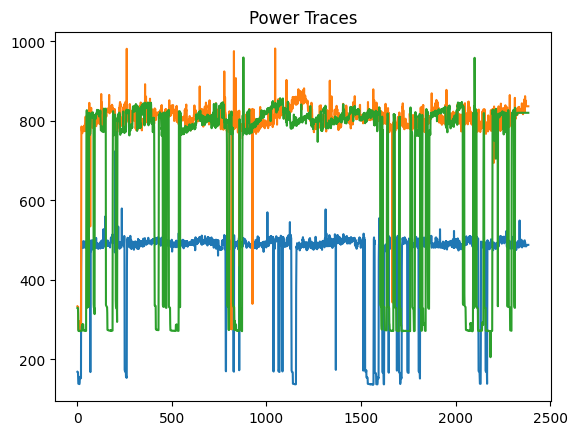

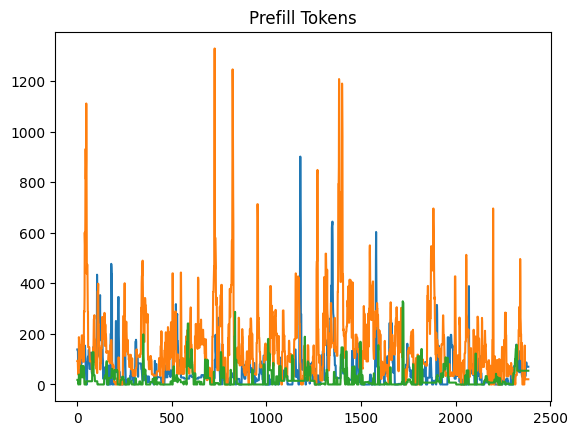

Text(0.5, 1.0, 'Decode Tokens')

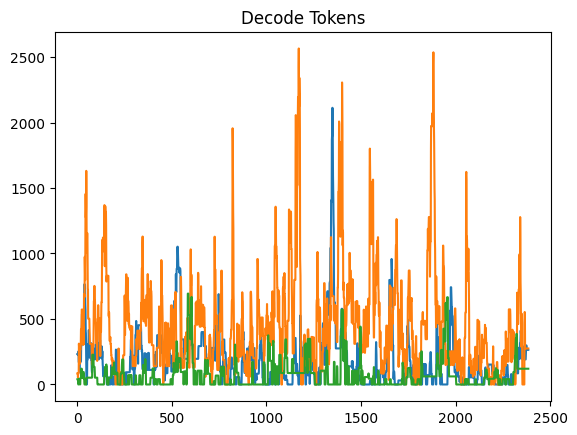

In [36]:
plt.plot(power_traces[0], label="Power Trace")
plt.plot(power_traces[1], label="Power Trace")
plt.plot(power_traces[2], label="Power Trace")
plt.title("Power Traces")
plt.show()
plt.plot(prefill_tokens[0], label="Prefill Tokens")
plt.plot(prefill_tokens[1], label="Prefill Tokens")
plt.plot(prefill_tokens[2], label="Prefill Tokens")
plt.title("Prefill Tokens")
plt.show()
plt.plot(decode_tokens[0], label="Decode Tokens")
plt.plot(decode_tokens[1], label="Decode Tokens")
plt.plot(decode_tokens[2], label="Decode Tokens")
plt.title("Decode Tokens")